# Data Analysis
---

Now that the data has been pulled in from the OOI, we can start looking at data quality and availability. There are several things we want to consider before we use this data in a model, including: 

- Data availability throughout 2017 - are there any extended periods of time where data is missing for any of the variables that I plan to use?
- Are there any annotations or flags placed on these times and sensors by the OOI itself? This can be checked on the ooinet website.
- What does the data look like? Can I see the effects of upwelling on these variables? Upwelling should be associated with cold, salty, oxygen-deprived water.
- What are the relationships between variables? Temperature and salinity should be inversed, what about temperature at the surface and temperature at 200 meters?
- Does the profiler data agree with the platform and surface mooring data? 
- What's the distribution of the upwelling index? Can I use that to choose thresholds for labeling my target variable? 

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make the plots look nicer
sns.set()

### Load data files

Load in the data files that were saved to the output folder by notebook `01_data_collection`.

In [2]:
METBK_data = pd.read_csv('../../coastal_upwelling_output/metbk_data.csv')
profiler_data = pd.read_csv('../../coastal_upwelling_output/profiler_data.csv')
platform_data = pd.read_csv('../../coastal_upwelling_output/platform_data.csv')

In [3]:
# Specify the variable(s) of interest
METBK_var = ['sea_surface_temperature', 'met_windavg_mag_corr_east', 'met_windavg_mag_corr_north']
profiler_var = ['seawater_pressure', 'density', 'practical_salinity', 'seawater_temperature', 'corrected_dissolved_oxygen']
platform_var = ['seawater_pressure', 'density', 'practical_salinity', 'seawater_temperature', 'dissolved_oxygen']

In [4]:
# Specify the units for each variable of interest
METBK_units = {'sea_surface_temperature': ['ºC'], 'met_windavg_mag_corr_east': ['m s-1'], 'met_windavg_mag_corr_north': ['m s-1']}
profiler_units = {'seawater_pressure': ['dbar'], 'density': ['kg m-3'], 'practical_salinity': ['1'], 'seawater_temperature': ['ºC'], 'corrected_dissolved_oxygen': ['µmol kg-1']}
platform_units = {'seawater_pressure': ['dbar'], 'density': ['kg m-3'], 'practical_salinity': ['1'], 'seawater_temperature': ['ºC'], 'dissolved_oxygen': ['µmol kg-1']}

### Quick general inspection
Let's see exactly how much data we're working with:

In [5]:
# Print shapes of dataframes:
print(METBK_data.shape)
print(profiler_data.shape)
print(platform_data.shape)

(485137, 4)
(21517483, 6)
(21413155, 6)


This is a ton of observations! We can resample the data into larger-grain resolutions later so that we aren't feeding 20M observations to our visaulizations and models.

Next, let's see what the data looks like:

In [6]:
METBK_data

time  sea_surface_temperature  \
0       2017-01-01 00:00:30.432000000                   11.273   
1       2017-01-01 00:01:37.298999808                   11.268   
2       2017-01-01 00:02:41.522000384                   11.267   
3       2017-01-01 00:03:46.300000256                   11.267   
4       2017-01-01 00:04:50.525000192                   11.278   
...                               ...                      ...   
485132  2017-12-01 18:28:40.451000320                   12.053   
485133  2017-12-01 18:29:44.697999872                   12.053   
485134  2017-12-01 18:30:16.942000128                   12.052   
485135  2017-12-01 18:31:21.691999744                   12.052   
485136  2017-12-01 18:32:26.453000192                   12.052   

        met_windavg_mag_corr_east  met_windavg_mag_corr_north  
0                    4.095093e+00               -7.196688e+00  
1                    6.134961e+00               -5.290137e+00  
2                    4.501072e+00               -4.933199e+00  
3                    3.296377e+00               -4.787901e+00  
4                    4.516634e+00               -4.688541e+00  
...                           ...                         ...  
485132              -1.228042e+07               -7.013654e+06  
485133              -1.228042e+07               -7.013654e+06  
485134              -1.228042e+07               -7.013654e+06  
485135              -1.228042e+07               -7.013654e+06  
485136              -1.228042e+07               -7.013654e+06  

[485137 rows x 4 columns]

In [7]:
profiler_data

time  seawater_pressure      density  \
0         2017-01-01 00:00:00.317937152         200.479041  1027.353099   
1         2017-01-01 00:00:01.318152192         200.473701  1027.353005   
2         2017-01-01 00:00:02.318157312         200.467264  1027.352763   
3         2017-01-01 00:00:03.317954560         200.465142  1027.352876   
4         2017-01-01 00:00:04.318168576         200.466196  1027.352835   
...                                 ...                ...          ...   
21517478  2017-09-16 12:13:36.480951808          55.887428  1026.093423   
21517479  2017-09-16 12:13:37.480647680          55.495146  1026.091836   
21517480  2017-09-16 12:13:38.480967680          55.449183  1026.101359   
21517481  2017-09-16 12:13:39.480977408          55.550728  1026.101385   
21517482  2017-09-16 12:13:40.481089536          55.674719  1026.098354   

          practical_salinity  seawater_temperature  corrected_dissolved_oxygen  
0                  33.886699              7.785772                  106.590066  
1                  33.886692              7.786201                  106.566439  
2                  33.886432              7.786262                  106.633814  
3                  33.886519              7.785895                  106.511052  
4                  33.886425              7.785711                  106.702620  
...                      ...                   ...                         ...  
21517478           33.515015              9.740724                  174.247648  
21517479           33.513691              9.733299                  174.247264  
21517480           33.524510              9.725553                  174.128022  
21517481           33.524760              9.729361                  174.092489  
21517482           33.521308              9.734784                  174.033241  

[21517483 rows x 6 columns]

In [8]:
platform_data

time  seawater_pressure      density  \
0         2017-01-01 00:00:00.358334464         174.119526  1027.258302   
1         2017-01-01 00:00:01.358341632         174.116325  1027.258472   
2         2017-01-01 00:00:02.358451712         174.112055  1027.258521   
3         2017-01-01 00:00:03.358353408         174.110987  1027.258479   
4         2017-01-01 00:00:04.359924736         174.109920  1027.258647   
...                                 ...                ...          ...   
21413150  2017-09-16 12:13:36.463305728         106.267688  1026.694767   
21413151  2017-09-16 12:13:37.463519744         105.983047  1026.693119   
21413152  2017-09-16 12:13:38.463524352         105.822521  1026.692393   
21413153  2017-09-16 12:13:39.464573440         105.612742  1026.691110   
21413154  2017-09-16 12:13:40.463225344         105.642707  1026.690872   

          practical_salinity  seawater_temperature  dissolved_oxygen  
0                  33.916341              7.767863        243.229175  
1                  33.916495              7.767433        243.231825  
2                  33.916536              7.767187        243.229405  
3                  33.916442              7.766941        243.233222  
4                  33.916615              7.766695        243.229099  
...                      ...                   ...               ...  
21413150           33.802832              8.837725        141.039036  
21413151           33.802465              8.838104        141.052233  
21413152           33.802463              8.838041        141.071164  
21413153           33.802138              8.838483        141.042114  
21413154           33.801812              8.839241        141.060716  

[21413155 rows x 6 columns]

We can see that the surface mooring data goes until 2017-12-01, but the profiler and platform data actually cut off at 2017-09-16 instead of covering the end of 2017. This is a constraint we can work with, though.

Do a quick check for nulls:

In [9]:
METBK_data.isna().sum()

time                              0
sea_surface_temperature           0
met_windavg_mag_corr_east     17981
met_windavg_mag_corr_north    17981
dtype: int64

I actually didn't expect to see nulls here, I thought they'd all be filled in with some predetermined fill value. We'll see in the notebook `04_preprocessing` that these nulls are all focused around one time period, it's possible that there was a sensor malfunction. 

In [10]:
profiler_data.isna().sum()

time                          0
seawater_pressure             0
density                       0
practical_salinity            0
seawater_temperature          0
corrected_dissolved_oxygen    0
dtype: int64

There are no nulls here because they've already been filled with designated values and flagged for removal, and seemingly removed, at some point in the backend quality assurance processes. 

In [11]:
platform_data.isna().sum()

time                    0
seawater_pressure       0
density                 0
practical_salinity      0
seawater_temperature    0
dissolved_oxygen        0
dtype: int64

Now we can do a deeper dive for each of these dataframes!

---
# METBK data

I'm starting with the bulk meteorology package which sits on a surface mooring and collects measurements at the air-sea interface. This is really convenient! First, I want to look at northerly wind data, because coastal upwelling is a wind-driven process, and then I want to see how variables at the sea surface change in response to these wind measurements. Luckily, this package has it all! 

In [12]:
METBK_data.dtypes

time                           object
sea_surface_temperature       float64
met_windavg_mag_corr_east     float64
met_windavg_mag_corr_north    float64
dtype: object

The time column is full of strings so we need to convert them to datetimes for plotting and resampling. While we're at it, let's do the same for the rest of the datasets.

In [13]:
# Convert time to datatime:
METBK_data['time'] = pd.to_datetime(METBK_data['time'])

# Do the same for the other dataframes:
profiler_data['time'] = pd.to_datetime(profiler_data['time'])
platform_data['time'] = pd.to_datetime(platform_data['time'])

In [14]:
METBK_data.dtypes

time                          datetime64[ns]
sea_surface_temperature              float64
met_windavg_mag_corr_east            float64
met_windavg_mag_corr_north           float64
dtype: object

Generate a quick plot of the sea surface temperature in this area.

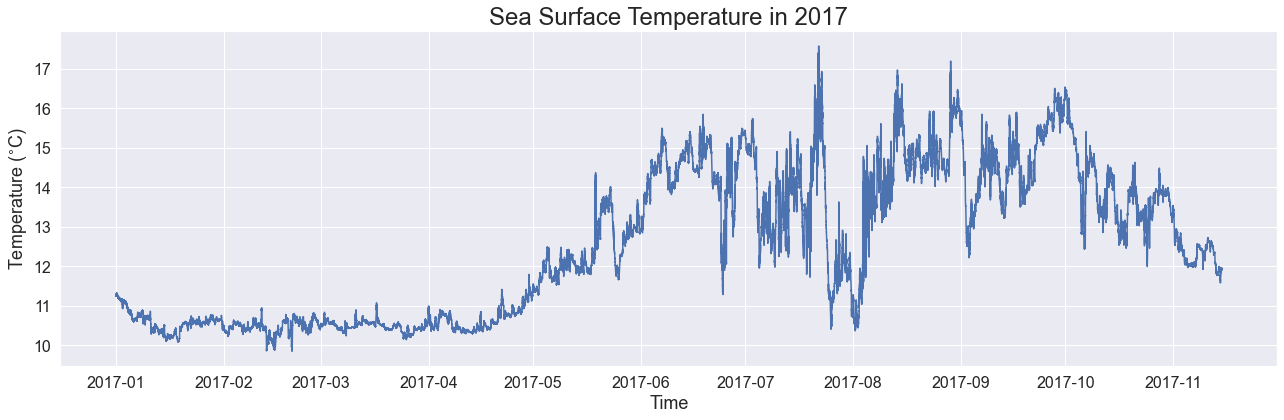

In [52]:
fig, ax = plt.subplots(1,1, sharex=True, figsize = (18, 6)) 

ax.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b')
ax.set_xlabel('Time', size=18)
ax.set_ylabel('Temperature ($^{\circ}$C)', size=18)

ax.set_title('Sea Surface Temperature in 2017', size=24)
plt.tick_params(axis='both', which='major', labelsize=16)

# plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('../figures/METBK_SST.png')

Generate a quick plot of the northward wind velocity data.

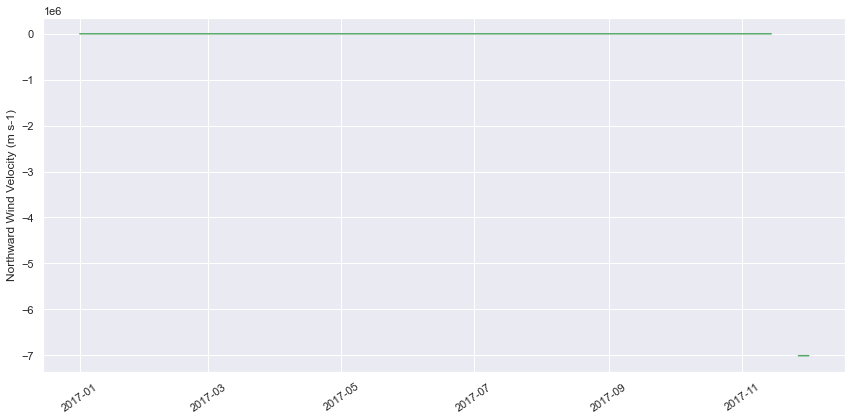

In [16]:
fig, ax = plt.subplots(1,1, sharex=True, figsize = (12, 6)) 

ax.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax.set_xlabel('')
ax.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))


plt.xticks(rotation=35);
plt.tight_layout()

Remember those nulls from before? They're screwing up this plot! Luckily, they're all at the end of the year, so we can slice them out. This won't interfere with plotting the data from the other sensors, because those sensors only cover January 1st to September 16th, so slice away!

In [17]:
mask = (METBK_data['time'][:] > '2017-01-01') & (METBK_data['time'] <= '2017-11-15')
METBK_data = METBK_data.loc[mask]

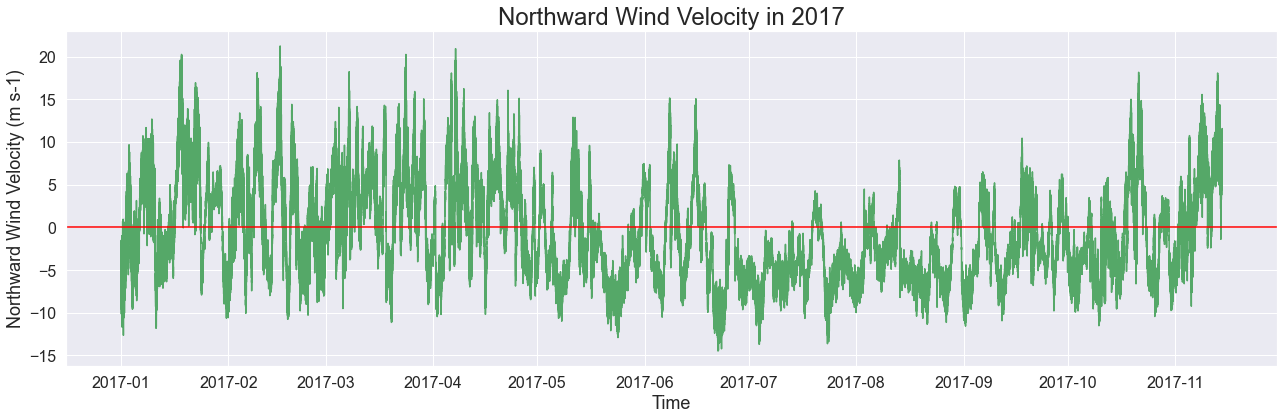

In [53]:
fig, ax = plt.subplots(figsize = (18, 6)) 

ax.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax.set_xlabel('Time', size=18)
ax.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=18)
ax.axhline(y=0, ls='-', c='red') # add horizontal line at 0


plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Northward Wind Velocity in 2017', size=24)

# testing out highlighting sections using background color
# start, end = '2017-01-01', '2017-01-02'
# ax1.axvspan(start, end, alpha=.2, color='r')
# trans = ax1.get_xaxis_transform()


# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/METBK_NWind.png')

Now combine this visual with the SST plot to look at them side by side.

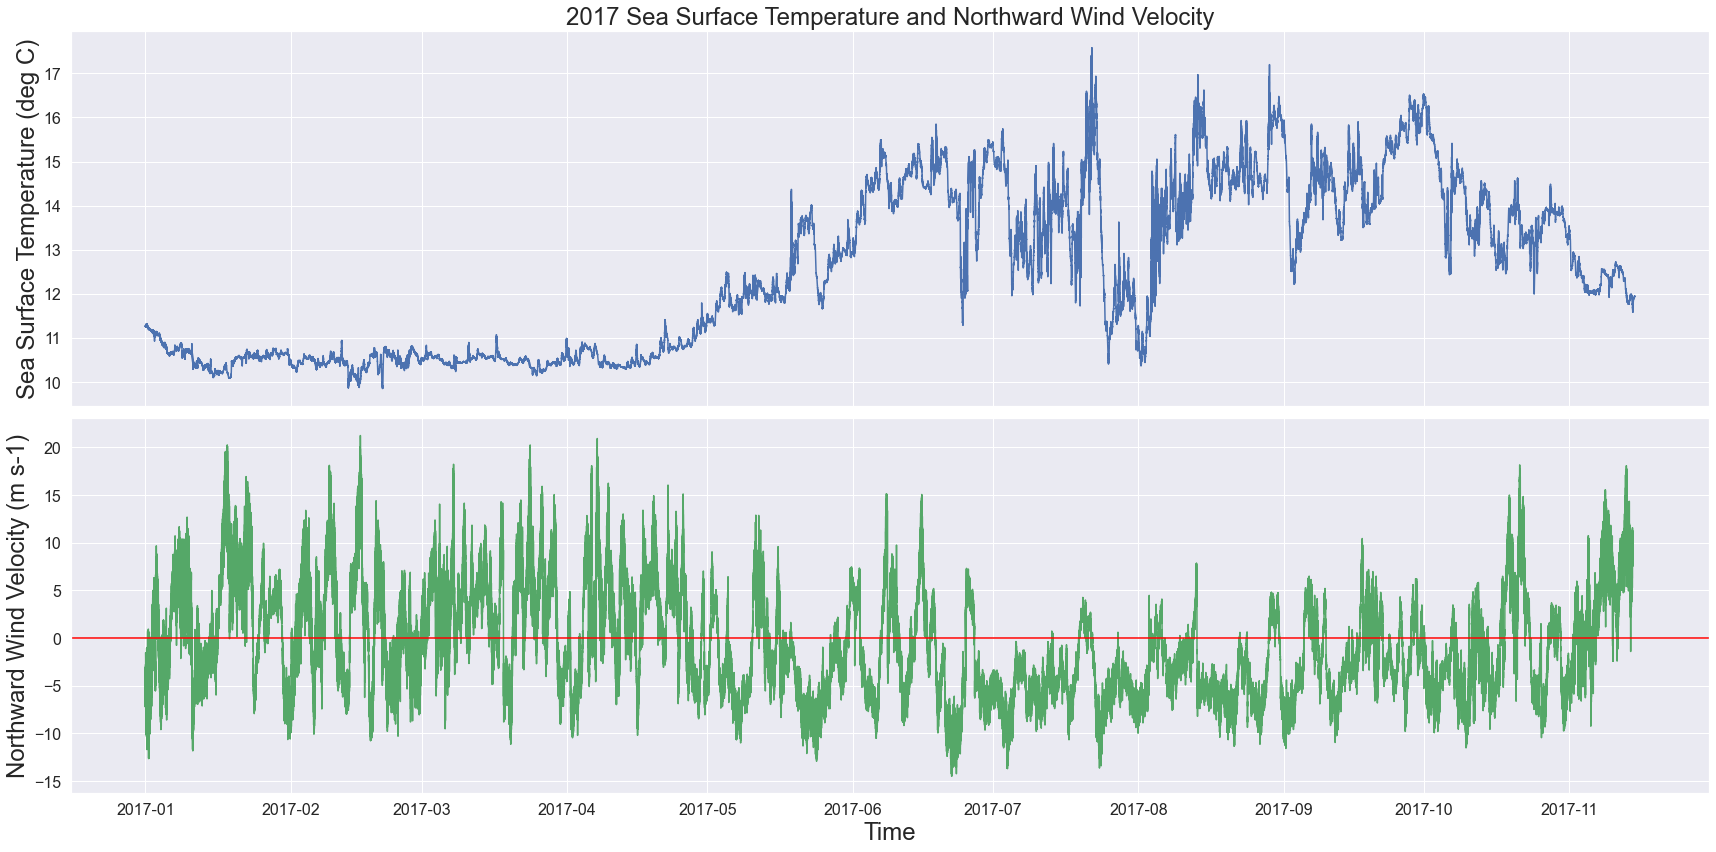

In [26]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
plt.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b')
ax1.set_ylabel('Sea Surface Temperature (deg C)', size=24)
ax1.set_title('2017 Sea Surface Temperature and Northward Wind Velocity', size=24)

ax2.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.axhline(y=0, ls='-', c='red') # add horizontal line at 0

ax1.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

# plt.xticks(rotation=35, fontsize=16);
# plt.yticks(fontsize=16);

# testing out highlighting sections using background color
# start, end = '2017-01-01', '2017-01-02'
# ax1.axvspan(start, end, alpha=.2, color='r')
# trans = ax1.get_xaxis_transform()


# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/METBK_SST_NWind.png')

The upper subplot shows sea surface tempreature (SST) measurements throughout the year, and the lower subplot shows the northward wind velocity. The red horizontal line represents a northward velocity of 0. When the green line is above 0, the wind is blowing to the North, and when it's below 0 the wind is blowing to the South. Southward blowing winds cause upwelling of cold waters in this environment, so we expect to see a decrease in sea surface temperatures when the northward wind velocity is negative.

Notice how cold and stable the temperature is in the winter months, keeping between ~10 and ~11 degrees C. The sea surface begins warming up in late April and May, and is considerably warmer in the summer months. 

Next, notice how irregular the temperature is in the summer months - this is probably due to the seasonal upwelling. The northward wind velocity is often positive in winter and spring months and often negative in summer and fall months. What we're hoping to see here is that **extended periods of negative northward wind velocities are followed by a sharp spike downward in the SST.** See if you can find spots like that in the plot above!

Keep in mind that northward wind velocity is not a perfect indicator of upwelling and that we'll need to use an official upwelling index to label our data for modeling. More on this later in the notebook. We can do a quick correlation and see whether northward wind velocity and SST might be related. 

In [54]:
METBK_data.corr()

sea_surface_temperature  \
sea_surface_temperature                    1.000000   
met_windavg_mag_corr_east                 -0.057329   
met_windavg_mag_corr_north                -0.364434   

                            met_windavg_mag_corr_east  \
sea_surface_temperature                     -0.057329   
met_windavg_mag_corr_east                    1.000000   
met_windavg_mag_corr_north                   0.176333   

                            met_windavg_mag_corr_north  
sea_surface_temperature                      -0.364434  
met_windavg_mag_corr_east                     0.176333  
met_windavg_mag_corr_north                    1.000000

The correlation between sea_surface_temperature and met_windavg_mag_corr_north is only -0.364434. 

This data has a super high temporal resolution (something to be grateful for) but we can resample it to hourly and daily means to reduce the amount of observations we're plotting. Resampling the CTD data will be more important because it has tens of millions of observations, but I'll do it here just for consistency.

In [55]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()
METBK_hourly

time  sea_surface_temperature  met_windavg_mag_corr_east  \
0    2017-01-01 00:00:00                11.268333                   4.348728   
1    2017-01-01 01:00:00                11.264600                   4.470534   
2    2017-01-01 02:00:00                11.257867                   5.828099   
3    2017-01-01 03:00:00                11.252350                   5.794522   
4    2017-01-01 04:00:00                11.271867                   6.989749   
...                  ...                      ...                        ...   
7627 2017-11-14 19:00:00                11.903050                        NaN   
7628 2017-11-14 20:00:00                11.901317                        NaN   
7629 2017-11-14 21:00:00                11.918254                        NaN   
7630 2017-11-14 22:00:00                11.942672                        NaN   
7631 2017-11-14 23:00:00                11.940667                        NaN   

      met_windavg_mag_corr_north  
0                      -5.135321  
1                      -4.484457  
2                      -4.564354  
3                      -7.796951  
4                      -6.915843  
...                          ...  
7627                         NaN  
7628                         NaN  
7629                         NaN  
7630                         NaN  
7631                         NaN  

[7632 rows x 4 columns]

In [56]:
METBK_daily = METBK_data.resample('D', on='time').mean().dropna(how='all').reset_index()
METBK_daily

time  sea_surface_temperature  met_windavg_mag_corr_east  \
0   2017-01-01                11.247412                   6.413056   
1   2017-01-02                11.149430                  -1.148830   
2   2017-01-03                11.089363                  -5.203772   
3   2017-01-04                10.926763                  -6.222477   
4   2017-01-05                10.756387                  -6.911579   
..         ...                      ...                        ...   
313 2017-11-10                12.468681                  -0.408066   
314 2017-11-11                12.591080                   0.274552   
315 2017-11-12                12.417127                  -0.501287   
316 2017-11-13                11.889144                   4.022042   
317 2017-11-14                11.876774                   3.936518   

     met_windavg_mag_corr_north  
0                     -5.371468  
1                     -1.207261  
2                      2.533484  
3                     -4.027738  
4                     -3.048631  
..                          ...  
313                    4.630594  
314                    4.486309  
315                    8.977260  
316                   10.856365  
317                    6.797973  

[318 rows x 4 columns]

The resulting dataframes are much smaller, which will speed up plotting.

We can quickly calculate the percentage of time in 2017 that winds are blowing towards the south and get an idea of how much of the year might see favorable conditions for upwelling. Again, northward wind velocity is not the only indicator of upwelling conditions, we'll need to look at a calculated index for that later.

In [57]:
north_winds = np.array(METBK_data['met_windavg_mag_corr_north'])
upwelling_percentage = len(north_winds[north_winds < 0]) / len(north_winds) * 100
print('{}%'.format(round(upwelling_percentage)))

58%


Winds are blowing from north to south for about 58% of 2017 (minus the last couple of weeks of the year that contained nulls).

### Summer months

We can zoom in on just a few months worth of data to get a closer look at negative northward wind velocities and downward spikes in sea surface temperature.

In [58]:
# Grab times of interest
mask = (METBK_hourly['time'][:] > '2017-04-01') & (METBK_hourly['time'] <= '2017-08-01')
METBK_summer_data = METBK_hourly.loc[mask]

METBK_summer_data.head()

time  sea_surface_temperature  met_windavg_mag_corr_east  \
2161 2017-04-01 01:00:00                10.822590                   0.803592   
2162 2017-04-01 02:00:00                10.635898                   0.310431   
2163 2017-04-01 03:00:00                10.660164                   1.038492   
2164 2017-04-01 04:00:00                10.632017                   0.945587   
2165 2017-04-01 05:00:00                10.704410                   0.654626   

      met_windavg_mag_corr_north  
2161                   -2.903407  
2162                   -2.673502  
2163                   -2.400807  
2164                   -2.576699  
2165                   -2.115579

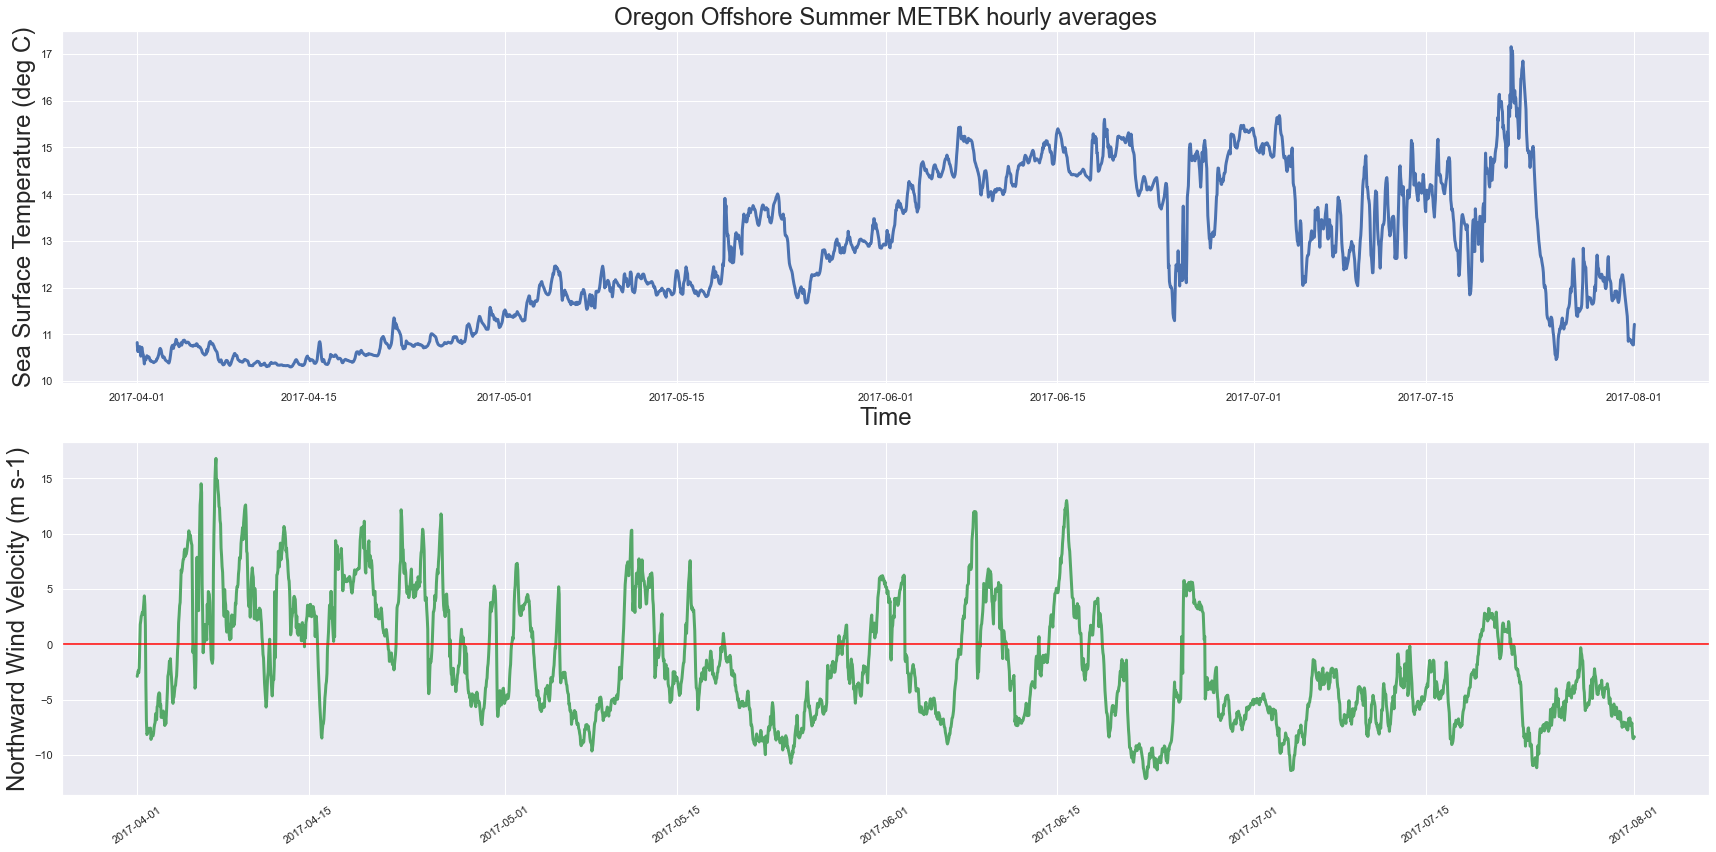

In [59]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(24, 12))

#ax2 = ax.twinx()  # instantiate a second axis that shares the same x-axis
ax.plot(METBK_summer_data['time'], METBK_summer_data['sea_surface_temperature'], 'b', linewidth=3)
ax.set_ylabel('Sea Surface Temperature (deg C)', size=24)
ax.set_xlabel('Time', size=24)

ax2.plot(METBK_summer_data['time'], METBK_summer_data['met_windavg_mag_corr_north'], 'g', linewidth=3)
ax2.set_ylabel('Northward Wind Velocity (m s-1)', size=24)
plt.xticks(rotation=35)

ax2.axhline(y=0, ls='-', c='red') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/METBK_SST_NWind_summer.png')

Notice how much more smooth the resampled curves are.

Strong upwelling appears to be occuring in the summer months. We can zoom in on July and August in particular.

In [60]:
# Grab times of interest
mask = (METBK_hourly['time'][:] > '2017-07-01') & (METBK_hourly['time'] <= '2017-09-01')
METBK_summer_data = METBK_hourly.loc[mask]

METBK_summer_data.head()

time  sea_surface_temperature  met_windavg_mag_corr_east  \
4345 2017-07-01 01:00:00                15.242525                   2.846418   
4346 2017-07-01 02:00:00                15.225610                   2.414451   
4347 2017-07-01 03:00:00                15.173885                   2.264922   
4348 2017-07-01 04:00:00                15.047683                   2.083661   
4349 2017-07-01 05:00:00                14.987576                   1.861326   

      met_windavg_mag_corr_north  
4345                   -4.989696  
4346                   -5.281305  
4347                   -5.292328  
4348                   -5.317052  
4349                   -4.960291

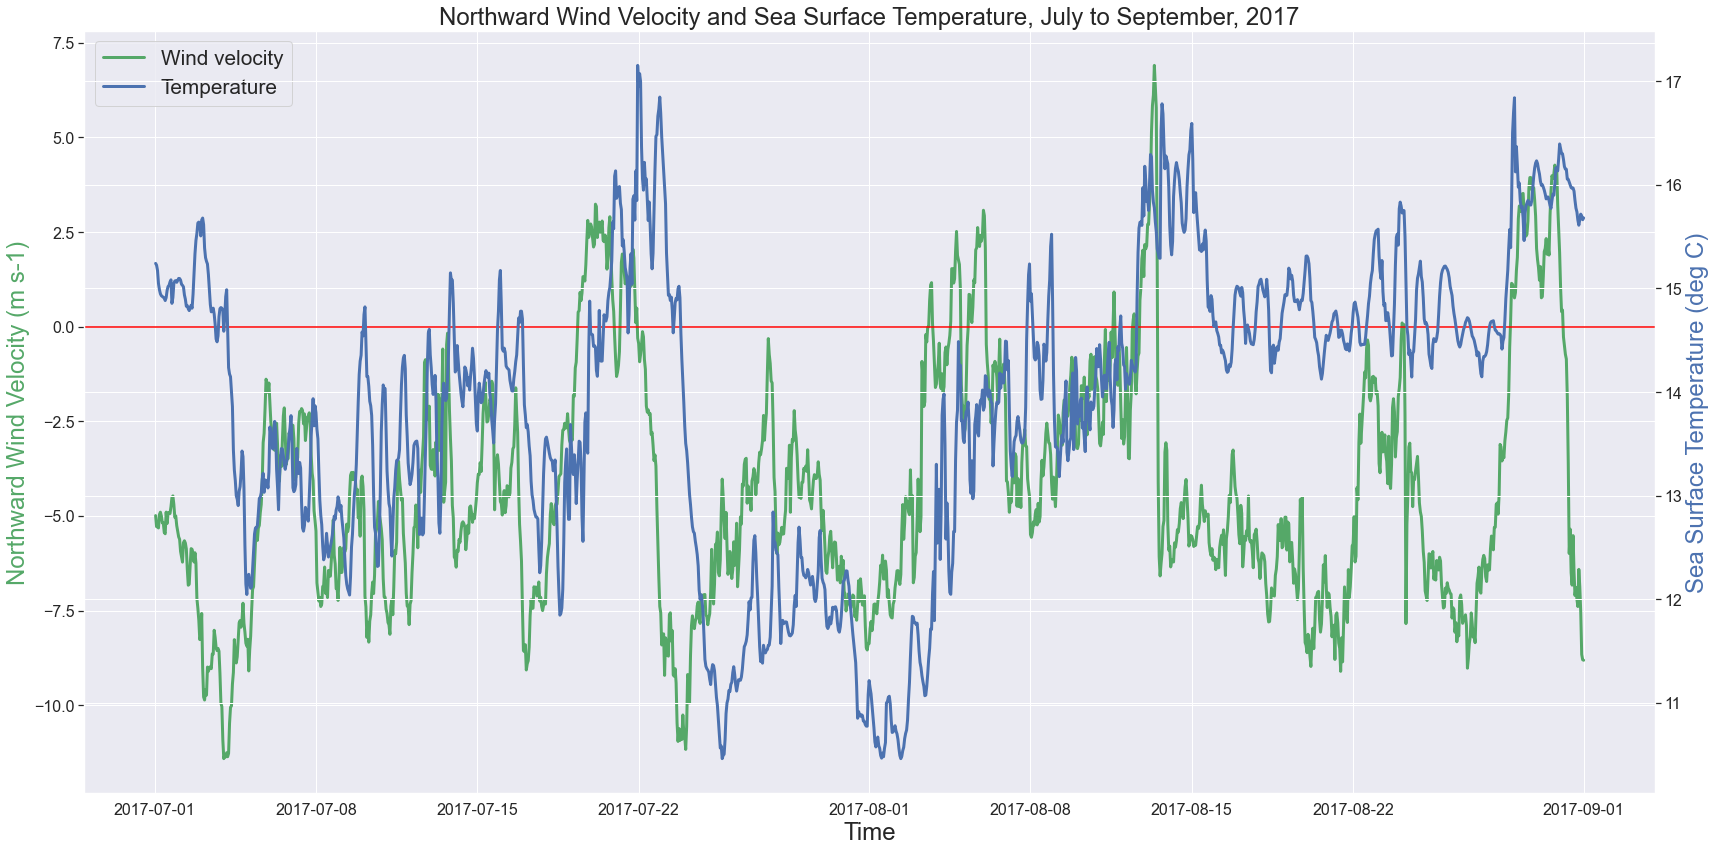

In [61]:
fig, ax1 = plt.subplots(figsize = (24, 12)) 


a, = ax1.plot(METBK_summer_data['time'], METBK_summer_data['met_windavg_mag_corr_north'], 'g', linewidth=3, label='Wind velocity')

ax1.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24, c='g')
ax1.axhline(y=0, ls='-', c='red') # add horizontal line at 0

ax2 = ax1.twinx()
b, = ax2.plot(METBK_summer_data['time'], METBK_summer_data['sea_surface_temperature'], 'b', linewidth=3, label='Temperature')
ax2.set_ylabel('Sea Surface Temperature (deg C)', size=24, c='b')
ax2.set_title('Northward Wind Velocity and Sea Surface Temperature, July to September, 2017', size=24)

ax1.set_xlabel('Time', size=24)
ax1.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

# start, end = '2017-01-01', '2017-01-02'
# ax1.axvspan(start, end, alpha=.2, color='r')
# trans = ax1.get_xaxis_transform()

p = [a, b]
ax1.legend(p, [p_.get_label() for p_ in p],
           loc= 'upper left', fontsize= 'xx-large')


# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/SST_NWind_zoomed_in.png')

Is it easier to see the connection between wind velocity and sea surface temperature now? There's a bit of a lag in time between southward blowing winds and colder temperature measurements but the relationship is clear. When northward wind velocity is strongly negative, SST drops considerably. 

---
# Profiler data
The next task is to look at the CTD data collected by the shallow profiler. The profiler we're using goes up and down in the water column on a wire, from ~20 meters to ~200 meters, 9 times a day. This will give us a better picture of how the full upper water column changes in upwelling conditions.

Ever tried plotting 20M observations? Neither have I, and I don't want to start now! We can resample the CTD data to a 1 minute scale, an hourly scale, and a daily scale. I have lots of questions about whether or not this is really a good idea though. If the profiler is moving up and down through the water column on a schedule, then looking at resampled data could actually give us an incorrect impression of the temperature patterns in the water column. This is something I need to come back to later; for now, let's resample and continue on.

In [51]:
profiler_data['time']

0          2017-01-01 00:00:00.317937152
1          2017-01-01 00:00:01.318152192
2          2017-01-01 00:00:02.318157312
3          2017-01-01 00:00:03.317954560
4          2017-01-01 00:00:04.318168576
                        ...             
21517478   2017-09-16 12:13:36.480951808
21517479   2017-09-16 12:13:37.480647680
21517480   2017-09-16 12:13:38.480967680
21517481   2017-09-16 12:13:39.480977408
21517482   2017-09-16 12:13:40.481089536
Name: time, Length: 21517483, dtype: datetime64[ns]

In [52]:
profiler_minutes = profiler_data.resample('T', on='time').mean().dropna(how='all').reset_index()
METBK_minutes = METBK_data.resample('T', on='time').mean().dropna(how='all').reset_index()
# profiler_minutes.head()

profiler_hourly = profiler_data.resample('H', on='time').mean().dropna(how='all').reset_index()
# profiler_hourly.head()

profiler_daily = profiler_data.resample('D', on='time').mean().dropna(how='all').reset_index()
# profiler_daily.head()

Now we can see how the profiler data looks:

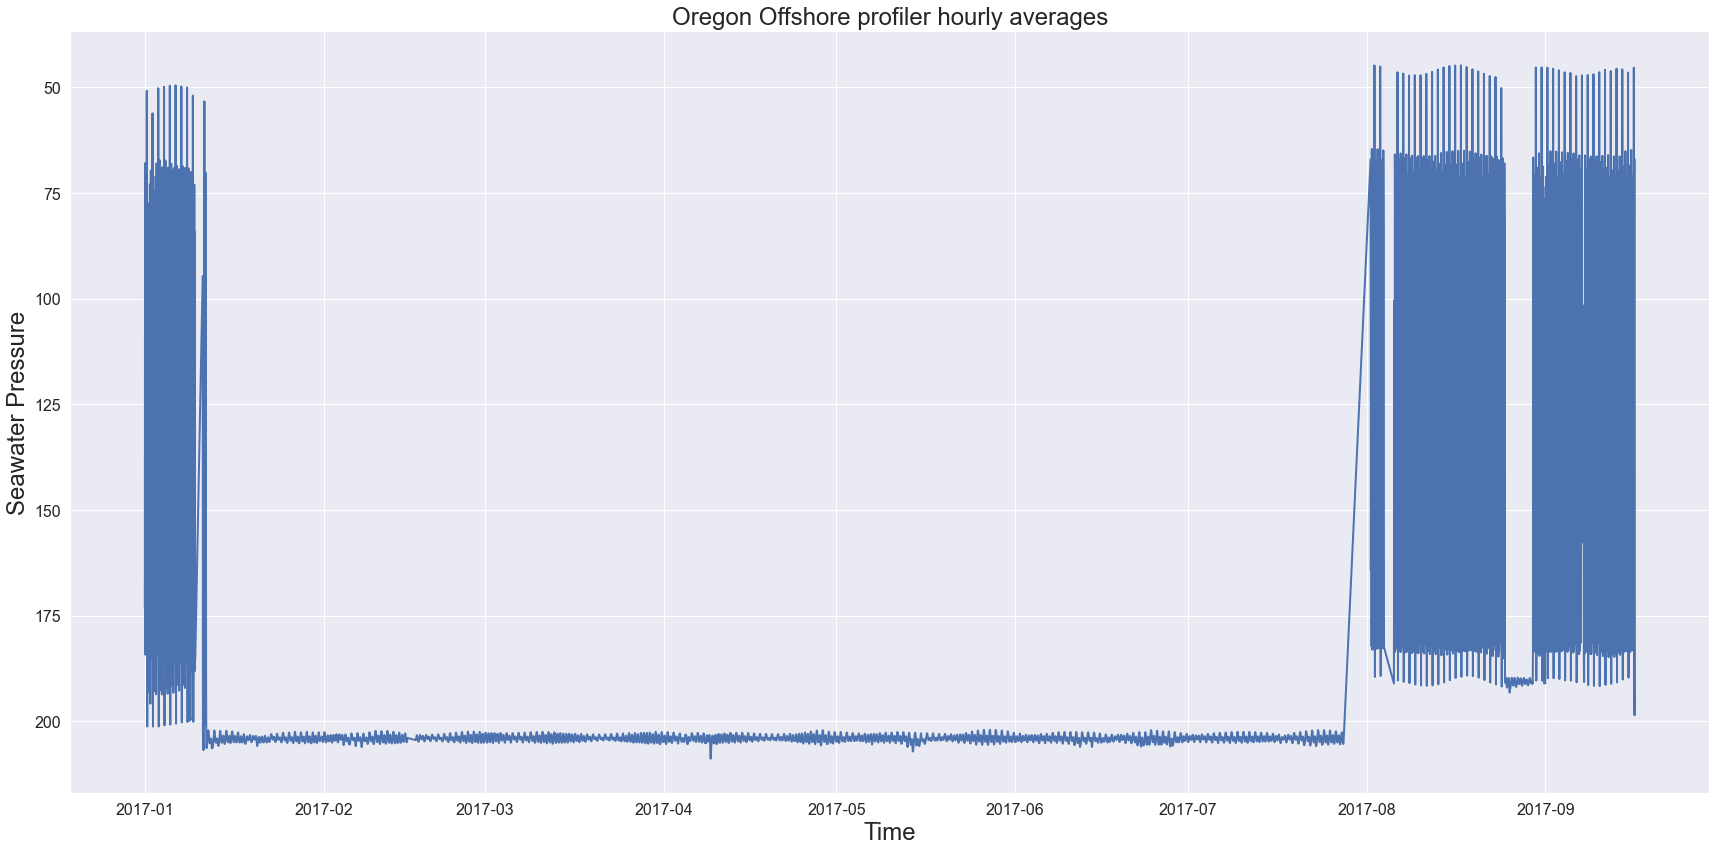

In [59]:
# Plot hourly-averaged METBK data
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 12))
ax.plot(profiler_hourly['time'], profiler_hourly['seawater_pressure'], 'b', linewidth=2)
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Pressure', size=24)
ax.set_title('Oregon Offshore profiler hourly averages', size=24)
ax.invert_yaxis()

plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout();
plt.savefig('../figures/2017_profiler.png')

You might be wondering what you're looking at here. Like I said, the profiler goes up and down in the water column, so I plotted seawater pressure (near equivalent to depth) on the y-axis. Unfortunately, it looks like the profiler got stuck at ~200 meters for about 6 months in 2017 and wasn't moving up and down in the water column like normal. I wonder if the 2018 data is any better? We can opt out of using the profiler data in the modeling, but let's still explore it before we move on to the 200 meter platform data.

To give you a better idea of what the profiler is doing, I'm going to select 5 days of data to plot.

In [60]:
mask = (profiler_data['time'][:] > '2017-08-20') & (profiler_data['time'] <= '2017-08-25')
profiler_week = profiler_data.loc[mask]

profiler_week.shape

(431988, 6)

Even 5 days of data is still almost half a million observations, wow! The cell below will take a few seconds to run

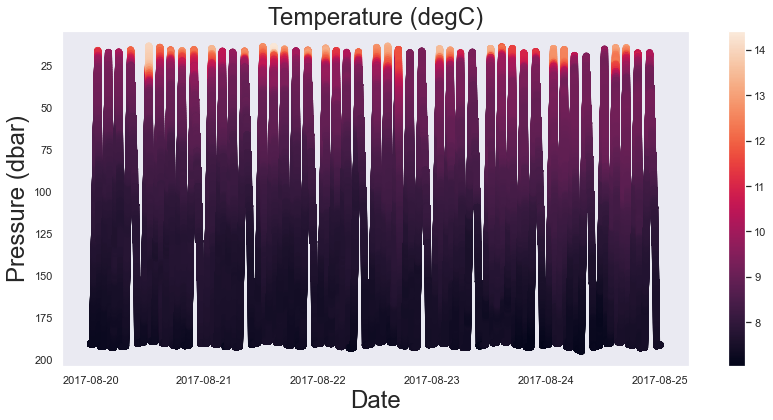

In [57]:
fig, ax = plt.subplots(figsize=(12,6))

ax.invert_yaxis()
ax.grid()

sc = ax.scatter(profiler_week['time'],profiler_week['seawater_pressure'],c=profiler_week['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/CTD_profiler_5days.png')

I hope this visual helps you understand the profiler's trips up and down through the water column. The colors on this plot shows seawater temperature and you can now see how temperature changes with depth - water is warmer near the surface and colder near 200 meters. Theoretically, this temperature pattern should change when there's upwelling of cold water. When there's upwelling, we expect to see cold water closer to the surface.

Also, did you notice how wavy the top and bottom edges of the profiler data is? I'm guessing the depth that the profiler can get to changes according to the position of the wire it's on, which would be impacted by tidal cycles. That would mean this wavy pattern is being caused by the daily tides! I think it's so cool that that showed up in this data even though I wasn't looking for it - just another reason that I love working with ocean data.

We can generate similar plots with salinity, dissolved oxygen, and density. Each of these variables should have a similar or identical pattern as the plot above. 

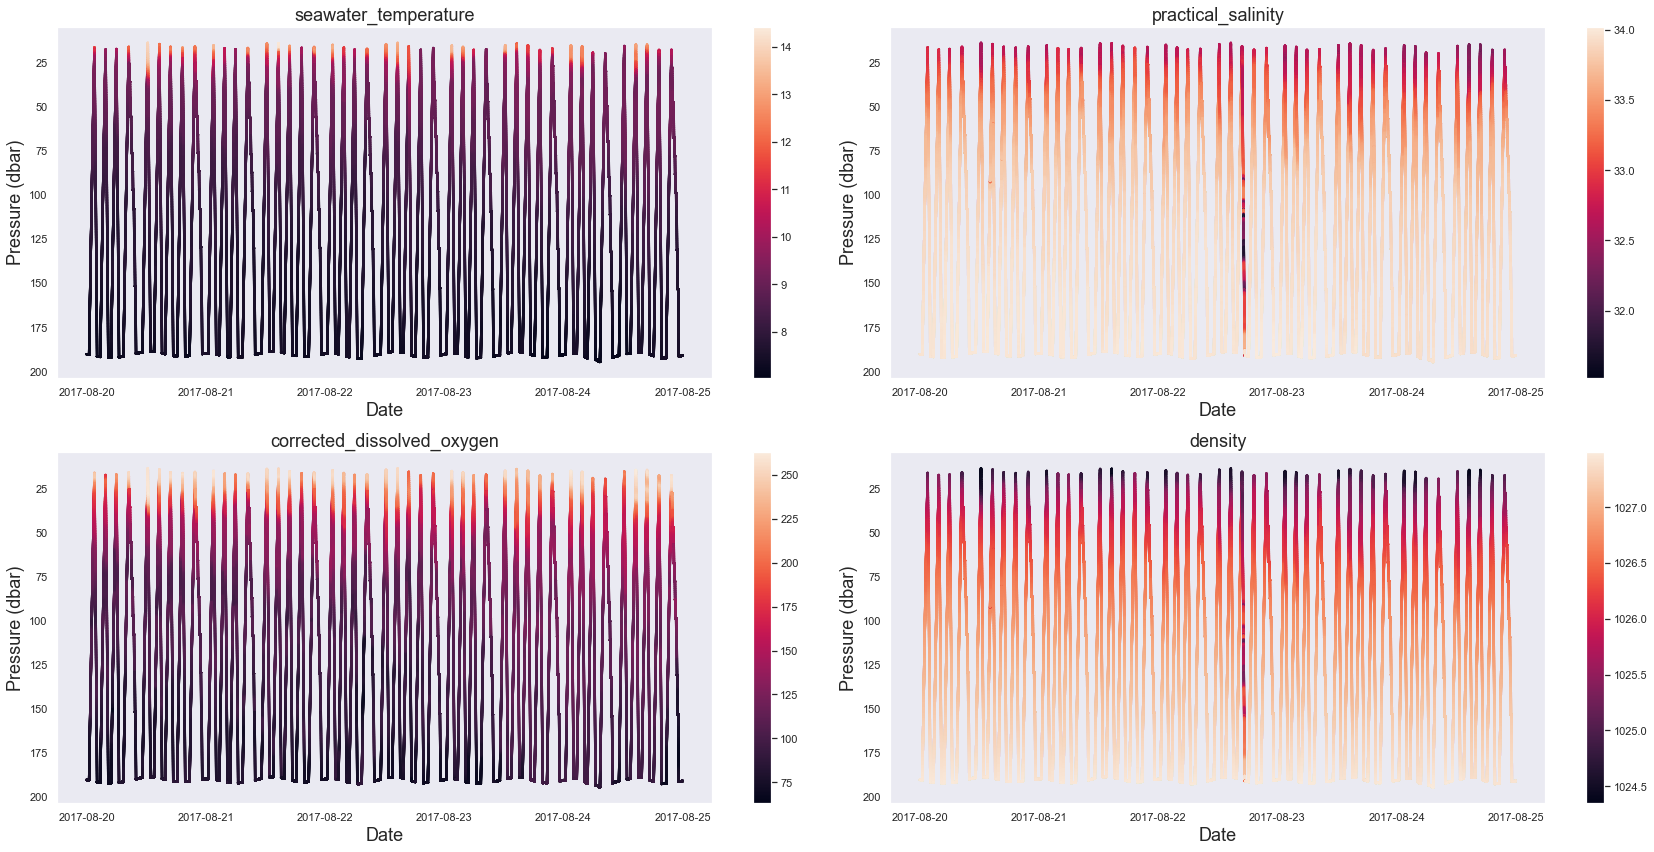

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

for ax in [ax1, ax2, ax3, ax4]:
    ax.invert_yaxis()
    ax.grid()
    ax.set_xlabel('Date', size=18)
    ax.set_ylabel('Pressure (dbar)', size=18)

#ax1.set_xlim(profiler_week['time'],profiler_week['time'])
sc = ax1.scatter(profiler_week['time'],profiler_week['seawater_pressure'],c=profiler_week['seawater_temperature'], s=2)
cb = fig.colorbar(sc,ax=ax1)
ax1.set_title('seawater_temperature', size=18)

sc = ax2.scatter(profiler_week['time'],profiler_week['seawater_pressure'],c=profiler_week['practical_salinity'], s=2)
cb = fig.colorbar(sc,ax=ax2)
ax2.set_title('practical_salinity', size=18)

sc = ax3.scatter(profiler_week['time'],profiler_week['seawater_pressure'],c=profiler_week['corrected_dissolved_oxygen'], s=2)
cb = fig.colorbar(sc,ax=ax3)
ax3.set_title('corrected_dissolved_oxygen', size=18)

sc = ax4.scatter(profiler_week['time'],profiler_week['seawater_pressure'],c=profiler_week['density'], s=2)
cb = fig.colorbar(sc,ax=ax4)
ax4.set_title('density', size=18)

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/CTD_profiler_multi.png')

Dissolved oxygen follows the same pattern as temperature (low values at depth, higher values near the surface), and salinity and density are inversed (high values at depth, lower values near the surface). There appears to be some wonky data in the salinity profile, which also shows up in density because density is calculated using temperature and salinity. These are the kinds of odd data points that we might try to clean up before we pass this data to a model. 

Note to self: I didn't get around to checking whether these particular stray data points got removed by the outlier checks in the preprocessing notebook, consider recreating these plots at the end of preprocessing to find out.

Next, let's zoom out and look at a couple of the summer months of data.

In [61]:
# Grab times of interest
mask = (profiler_data['time'][:] > '2017-04-01') & (profiler_data['time'] <= '2017-08-01')
profiler_summer = profiler_data.loc[mask]

profiler_summer.shape

(10193079, 6)

Brave enough to plot 10M observations? I'm not! Let's use the 1 minute resampled dataframe we created earlier.

In [62]:
mask = (profiler_minutes['time'][:] > '2017-04-01') & (profiler_minutes['time'] <= '2017-08-01')
profiler_summer_minutes = profiler_minutes.loc[mask]

profiler_summer_minutes.shape

(169898, 6)

In [63]:
profiler_data['seawater_pressure'].describe()

count    2.151748e+07
mean     1.892278e+02
std      3.956323e+01
min      1.355533e+01
25%      2.026819e+02
50%      2.037541e+02
75%      2.044697e+02
max      2.906436e+02
Name: seawater_pressure, dtype: float64

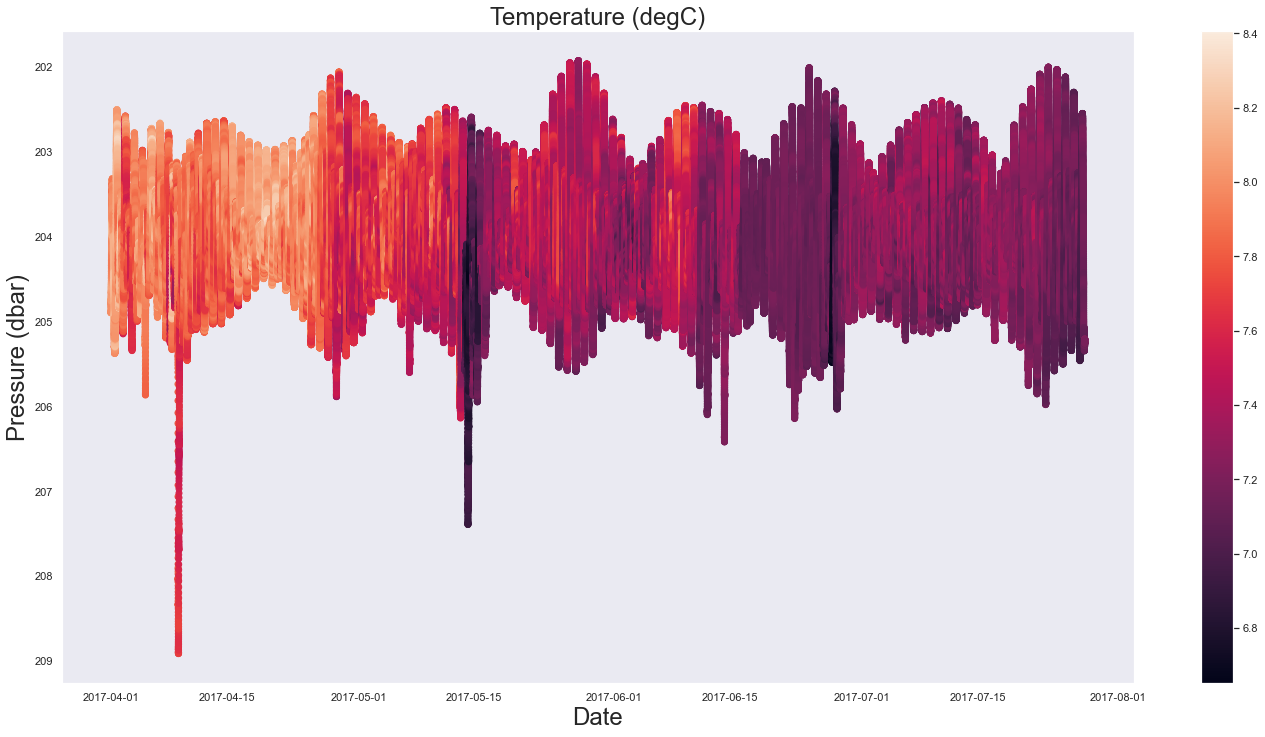

In [37]:
# source: https://github.com/cormorack/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_The xlim(profiler_data['time'],profiler_data['time'])
sc = ax.scatter(profiler_summer_minutes['time'],profiler_summer_minutes['seawater_pressure'],c=profiler_summer_minutes['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

This looks like some really cool abstract art. Unfortuantely, this is from a time period where the profiler was stuck around 200 meters. Let's try looking at the month of August instead.

In [64]:
mask = (profiler_minutes['time'][:] > '2017-08-01') & (profiler_minutes['time'] <= '2017-08-31')
profiler_august_minutes = profiler_minutes.loc[mask]

profiler_august_minutes.shape

(39771, 6)

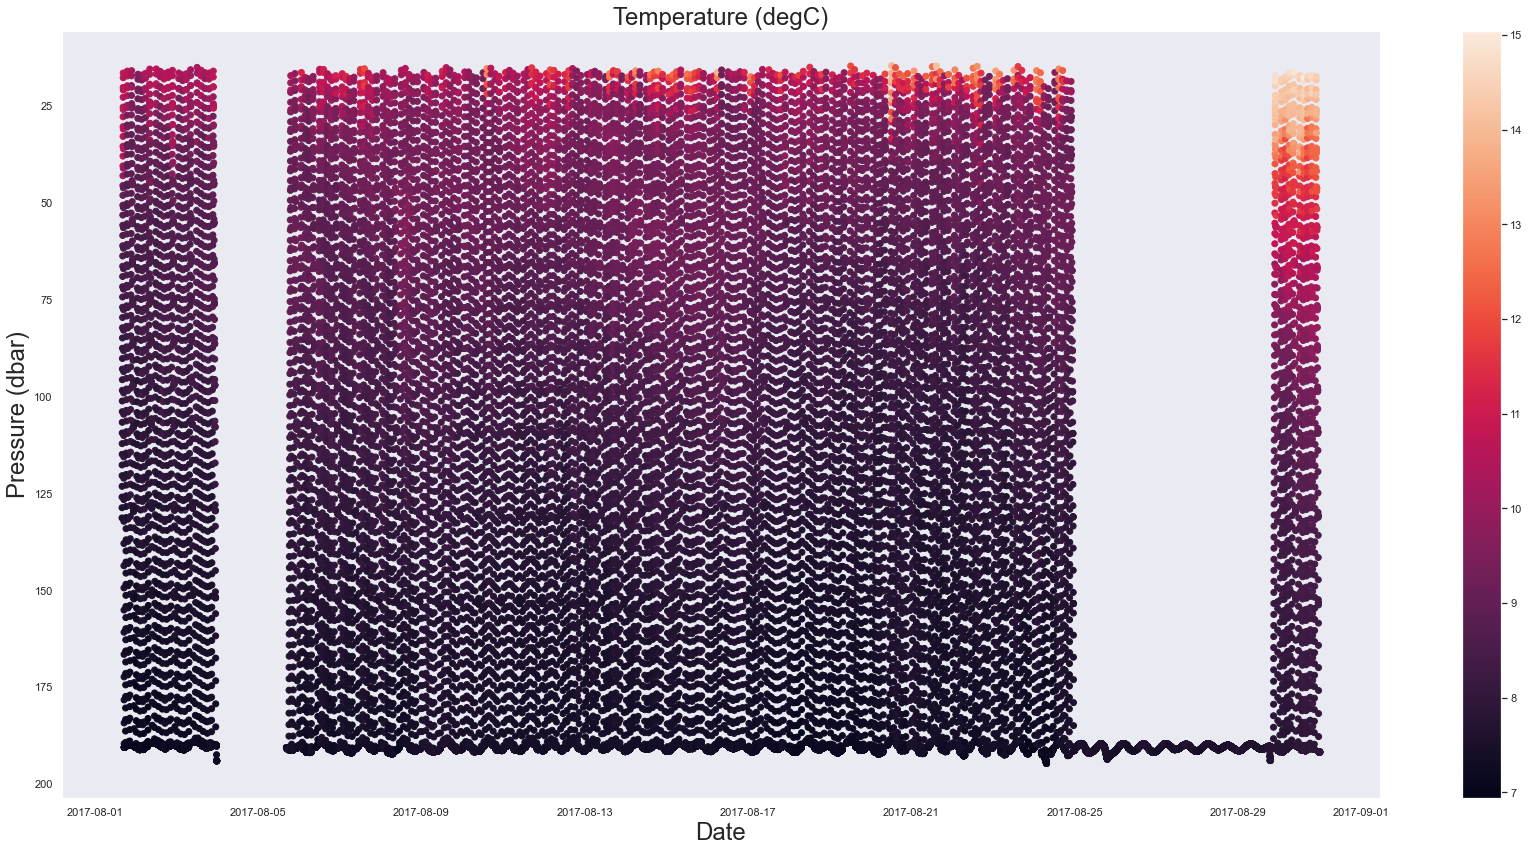

In [39]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_The xlim(profiler_data['time'],profiler_data['time'])
sc = ax.scatter(profiler_august_minutes['time'],profiler_august_minutes['seawater_pressure'],c=profiler_august_minutes['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/CTD_profiler_august_temp.png')

August has much better data availability for the profiler. If only the whole year looked like this! 

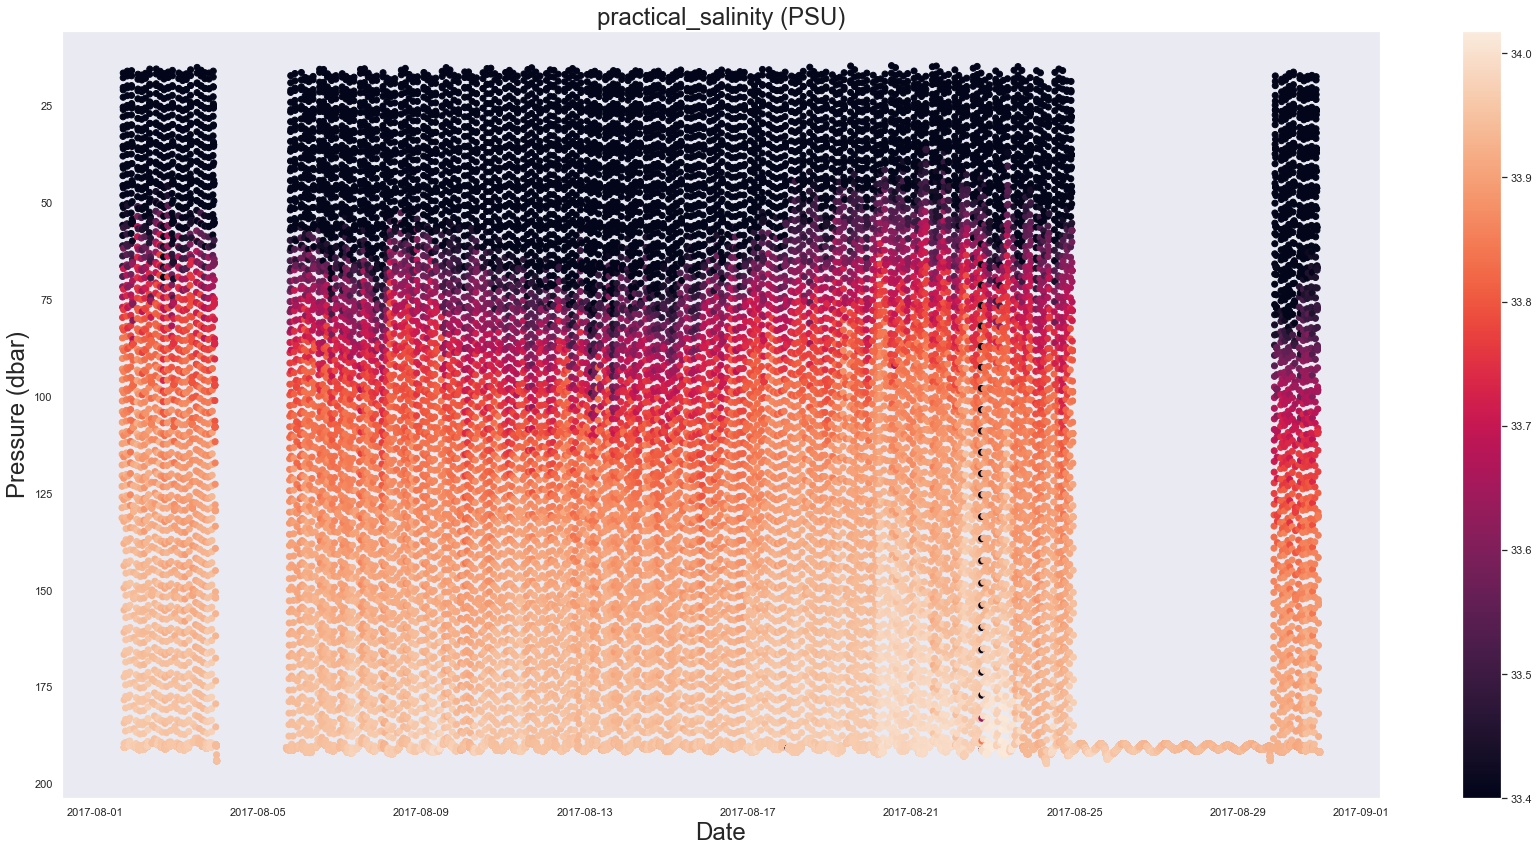

In [40]:
fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(profiler_data['time'],profiler_data['time'])
sc = ax.scatter(profiler_august_minutes['time'],profiler_august_minutes['seawater_pressure'],c=profiler_august_minutes['practical_salinity'], vmin=33.4)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('practical_salinity (PSU)', size=24)
cb = fig.colorbar(sc,ax=ax)

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/CTD_profiler_salinity.png')

I altered the vmin value in the salinity plot to emphasize the mixed layer depth - the boundary between high and low PSU sections of the water column. We can pull in the northward wind velocity and see if these depth changes line up with southward blowing wind. This would look like positive vecolicities when the mixed layer depth moves downward in the water column and negative velocities when it moves upward. 

In [62]:
mask = (METBK_hourly['time'][:] > '2017-08-01') & (METBK_hourly['time'] <= '2017-08-31')
METBK_august = METBK_hourly.loc[mask]

METBK_august.shape

(720, 4)

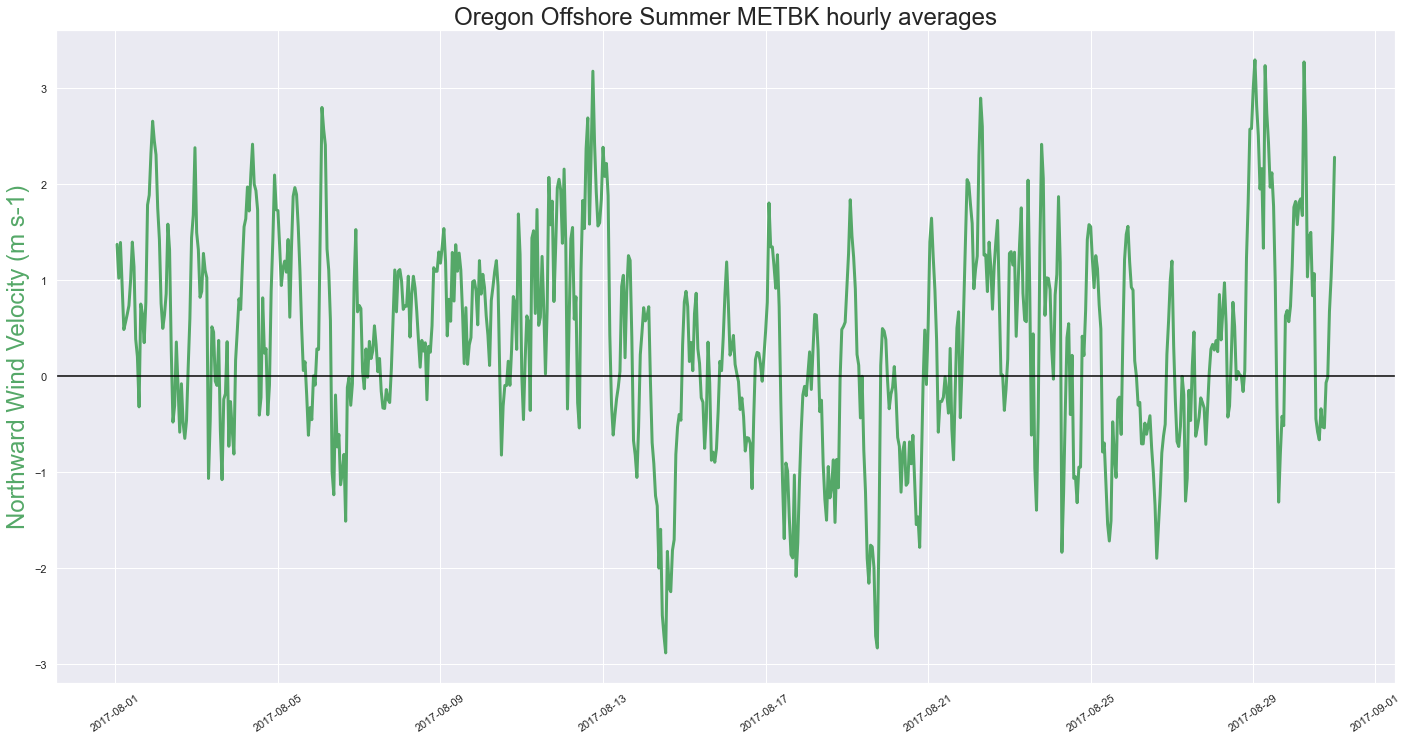

In [63]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_august['time'], METBK_august['met_windavg_mag_corr_east'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

Do you see it? The negative wind velocities between 08/13 and 08/21 are lined up with the rising of the mixed layer depth. Very cool!

---
### Platform data

Finally, we can look at the platform data. Hopefully it's more consistent than the profiler data! We'll do all the same steps we've already done - turn time into a datetime, resample, and plot!

In [64]:
platform_data.shape

(21413155, 6)

In [65]:
platform_minutes = platform_data.resample('T', on='time').mean().dropna(how='all').reset_index()

platform_hourly = platform_data.resample('H', on='time').mean().dropna(how='all').reset_index()

platform_daily = platform_data.resample('D', on='time').mean().dropna(how='all').reset_index()

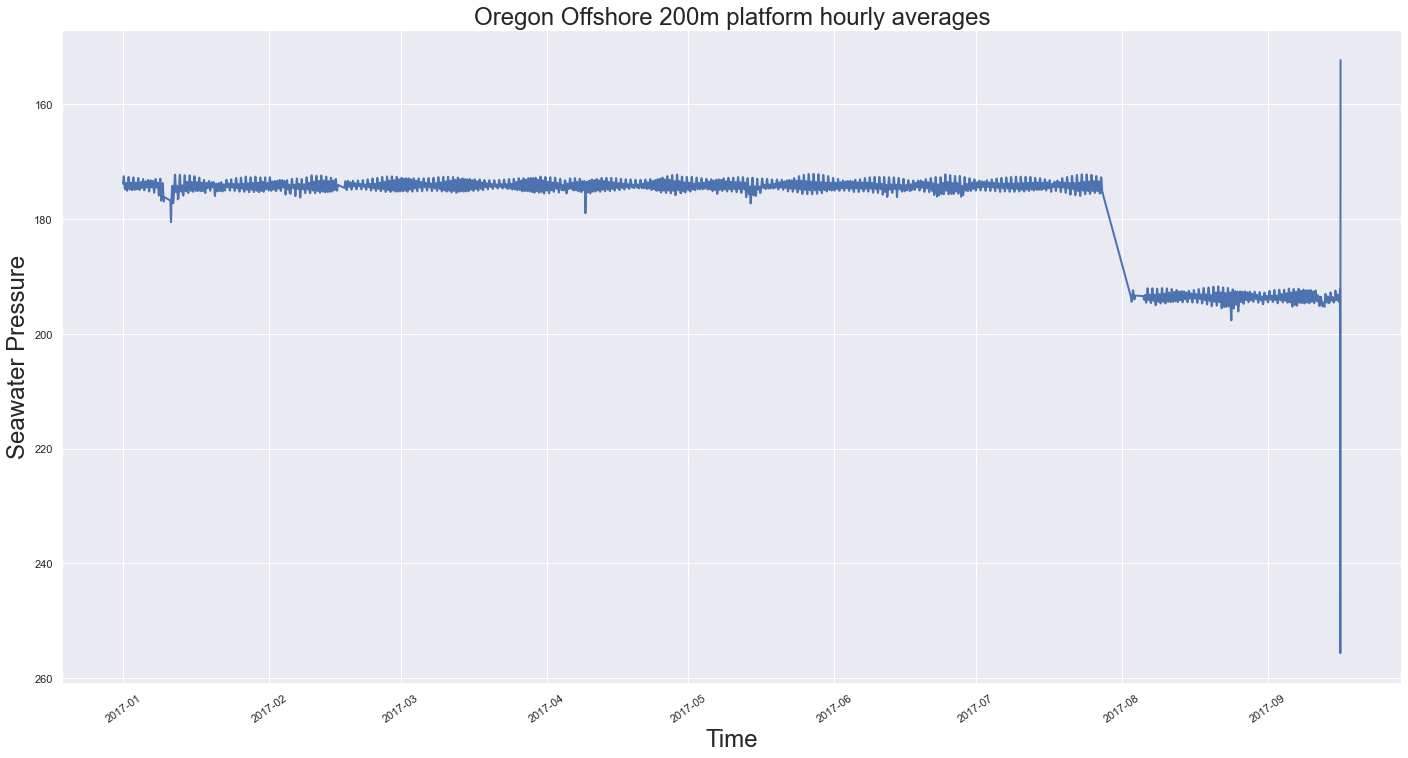

In [66]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 12))
ax.plot(platform_hourly['time'], platform_hourly['seawater_pressure'], 'b', linewidth=2)
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Pressure', size=24)
ax.set_title('Oregon Offshore 200m platform hourly averages', size=24)
ax.invert_yaxis()

plt.xticks(rotation=35);

Ahhh, the joys of working with real world data. For some reason, the platform's seawater pressure dropped suddenly between July and August from near 170 dbar to near 190 dbar. Let's look at the data anyway.

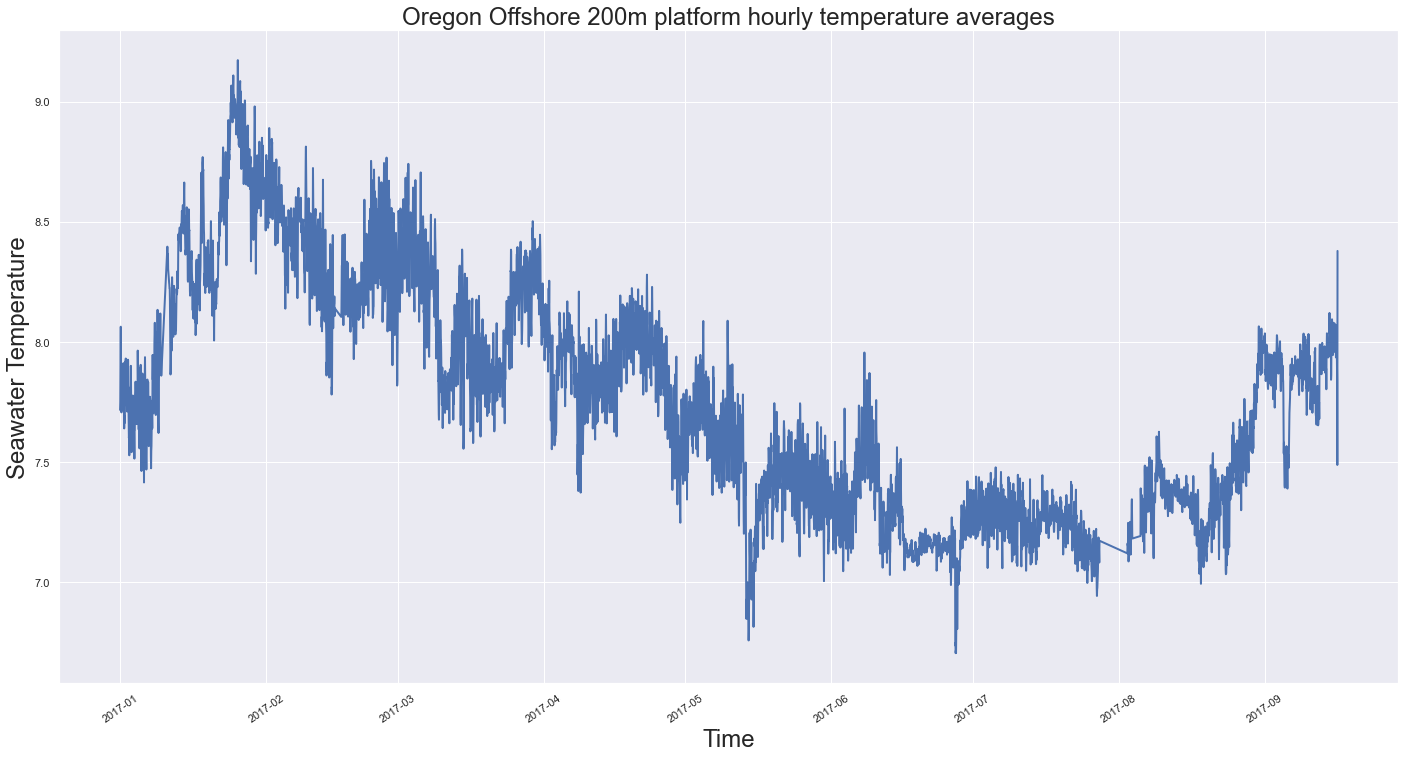

In [67]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 12))
ax.plot(platform_hourly['time'], platform_hourly['seawater_temperature'], 'b', linewidth=2)
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Temperature', size=24)
ax.set_title('Oregon Offshore 200m platform hourly temperature averages', size=24)

plt.xticks(rotation=35);

This is so fascinating! The temperature in the winter month is actually warmer than in the summer months around a depth of 200 meters. Let's see if the same seasonal changes can be seen in salinity.

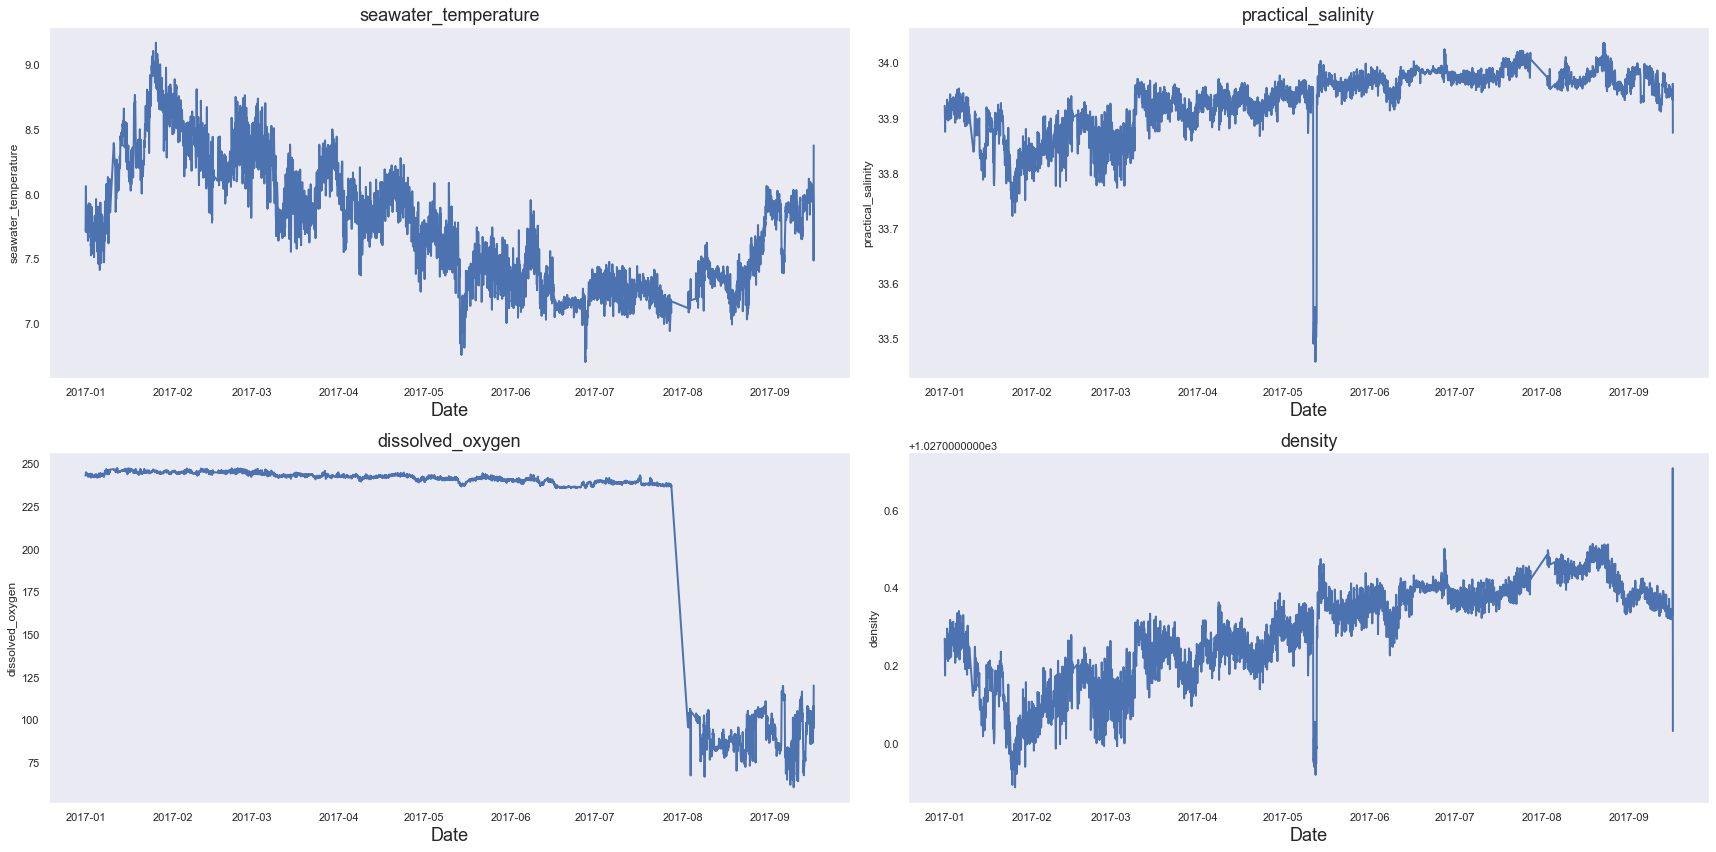

In [68]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()
    ax.set_xlabel('Date', size=18)

#ax1.set_xlim(profiler_week['time'],profiler_week['time'])
ax1.plot(platform_hourly['time'], platform_hourly['seawater_temperature'], 'b', linewidth=2)
ax1.set_title('seawater_temperature', size=18)
ax1.set_ylabel('seawater_temperature')

ax2.plot(platform_hourly['time'], platform_hourly['practical_salinity'], 'b', linewidth=2)
ax2.set_title('practical_salinity', size=18)
ax2.set_ylabel('practical_salinity')

ax3.plot(platform_hourly['time'], platform_hourly['dissolved_oxygen'], 'b', linewidth=2)
ax3.set_title('dissolved_oxygen', size=18)
ax3.set_ylabel('dissolved_oxygen')

ax4.plot(platform_hourly['time'], platform_hourly['density'], 'b', linewidth=2)
ax4.set_title('density', size=18)
ax4.set_ylabel('density')

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/platform_multi.png')

The dissolved oxygen data looks questionable, but the salinity and density are showing the inverse of the temperature data, just like we'd expect. There appears to be some funky data in May (see large spike downwards in salinity and density plots) and towards the end of the available data (September 16th I think), but the rest looks okay. This data reinforces the concept that this region sees seasonal upwelling in the summer that pulls deep water towards the sea surface. Since the effect is visible at depth, this data will be valuable in informing my models, alongside the SST collected by the surface mooring and potentially the profiler data if more of it were available in 2017. 

Another thing we can do is compare the METBK surface mooring data to this platform data. Unfortunately, the surface mooring doesn't have density calculations, so we'll have to compare temperature measurements.

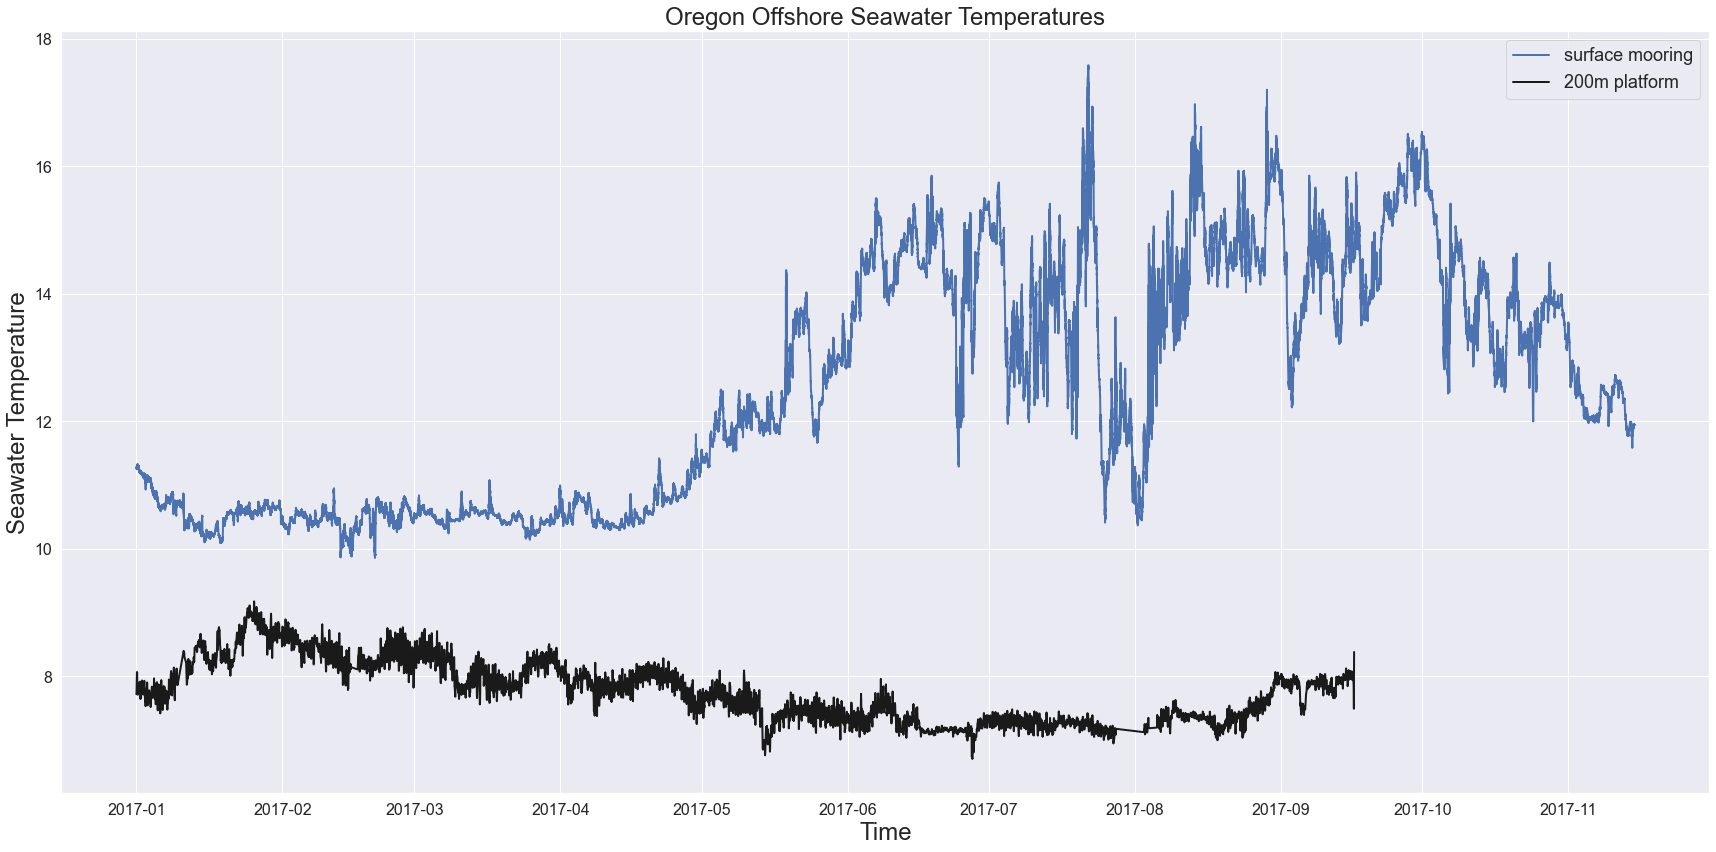

In [69]:
fig, ax = plt.subplots(1,1, sharex=True, figsize = (24, 12)) 

ax.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b', linewidth=2, label='surface mooring')
ax.set_ylabel('Sea Surface Temperature (deg C)', size=24)

ax.plot(platform_hourly['time'], platform_hourly['seawater_temperature'], 'k', linewidth=2, label='200m platform')
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Temperature', size=24)
ax.set_title('Oregon Offshore Seawater Temperatures', size=24)


ax1.set_xlabel('Time', size=24)
ax1.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)


plt.legend(fontsize=18)

# Set tight_layout and save the figure
plt.tight_layout()
plt.savefig('../figures/platform_METBK.png')

Amazing to see how much more varied the watercolumn is in the summer months than the winter months! 

I haven't looked at any distribution plots yet, let's do that quickly.

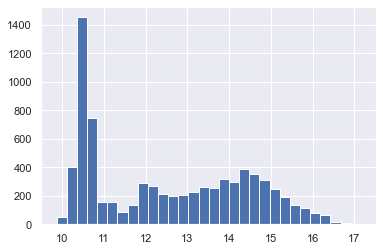

In [70]:
METBK_hourly['sea_surface_temperature'].hist(bins=30);

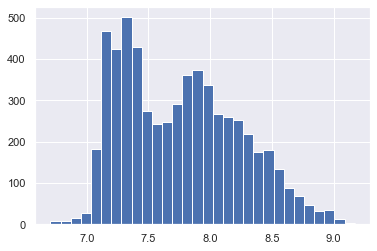

In [71]:
platform_hourly['seawater_temperature'].hist(bins=30);

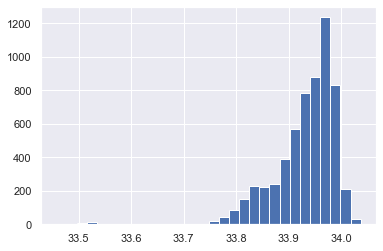

In [72]:
platform_hourly['practical_salinity'].hist(bins=30);

---
### Pull in upwelling index data

I followed the flowchart [provided here](https://oceanview.pfeg.noaa.gov/products/upwelling/which) to determine which upwelling index to use - I settled for the Coastal Upwelling Transport Index, or CUTI! **You'll need to download the CUTI daily indices csv file [from the ERD](https://oceanview.pfeg.noaa.gov/products/upwelling/dnld) and put it into the coastal upwelling output directory manually.** You can also [explore the CUTI data](https://heatherwelch.shinyapps.io/shiny_jacox_cuti/) online.

The CUTI index data includes a year, month, and day column. We can combine these and parse them as a datetime while reading in the data.

In [73]:
CUTI = pd.read_csv('../../coastal_upwelling_output/CUTI_daily.csv',
                  parse_dates=[[0,1,2]],
                  infer_datetime_format=True)

In [74]:
CUTI.rename(columns={'year_month_day':'time'},inplace=True)

This dataset contains index values for several latitudes along the west coast of North America. The OOI Oregon Offshore site is around 44.3 degrees North latitude, so we can use the 44N column, which covers 43.5 to 44.5 degrees North latitude. Since we don't need any other latitudes, we can select just the time and column '44N'.

In [75]:
mask = CUTI['time']
CUTI = CUTI[['time', '44N']]
CUTI

time    44N
0     1988-01-01 -0.043
1     1988-01-02 -0.440
2     1988-01-03 -0.514
3     1988-01-04  0.200
4     1988-01-05 -0.082
...          ...    ...
12139 2021-03-27 -0.011
12140 2021-03-28 -0.392
12141 2021-03-29  0.373
12142 2021-03-30  0.973
12143 2021-03-31  0.888

[12144 rows x 2 columns]

Now we can slice just the year 2017:

In [76]:
mask = (CUTI['time'][:] > '2017-01-01') & (CUTI['time'] <= '2017-11-15')
CUTI = CUTI.loc[mask].reset_index(drop=True)
CUTI

time    44N
0   2017-01-02  1.308
1   2017-01-03  0.360
2   2017-01-04  0.742
3   2017-01-05  1.469
4   2017-01-06  0.233
..         ...    ...
313 2017-11-11 -0.740
314 2017-11-12 -0.543
315 2017-11-13 -2.091
316 2017-11-14 -2.339
317 2017-11-15 -1.306

[318 rows x 2 columns]

In [77]:
CUTI.isna().sum()

time    0
44N     0
dtype: int64

In [78]:
CUTI.describe()

44N
count  318.000000
mean     0.072079
std      0.834682
min     -3.996000
25%     -0.351500
50%      0.128500
75%      0.597500
max      2.517000

Based on this, 50% of the calculated index values for the year 2017 are between -0.382000 and 0.654000. 

In [79]:
int(len(CUTI)**.5)

17

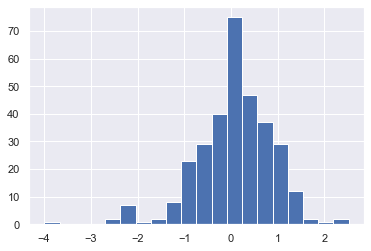

In [80]:
CUTI['44N'].hist(bins=20);

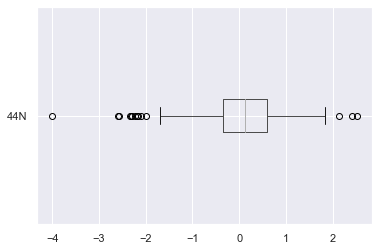

In [81]:
CUTI.boxplot(vert=False);

Most of the upwelling index values are between -1 and 1. Positive values here indicate favorable upwelling conditions, while negative values indicate favorable conditions for downwelling. Values near 0 are weak upwelling or downwelling according to their sign. In my first iteration of modeling, I one-hot encoded the upwelling index (1 for positive values, 0 for negative values) and got a maximum accuracy of ~74% using logistic regression, and ~79% using a decision tree classifier. This distribution plot might help me identify new thresholds for labeling my data. For instance, I can create a third class that contains all of the "in-between" indexing values that are near 0, since these are not associated with strong upwelling or downwelling using the upper and lower quartiles found above as my upper and lower thresholds.

Now let's compare the CUTI index to northward wind velocity.

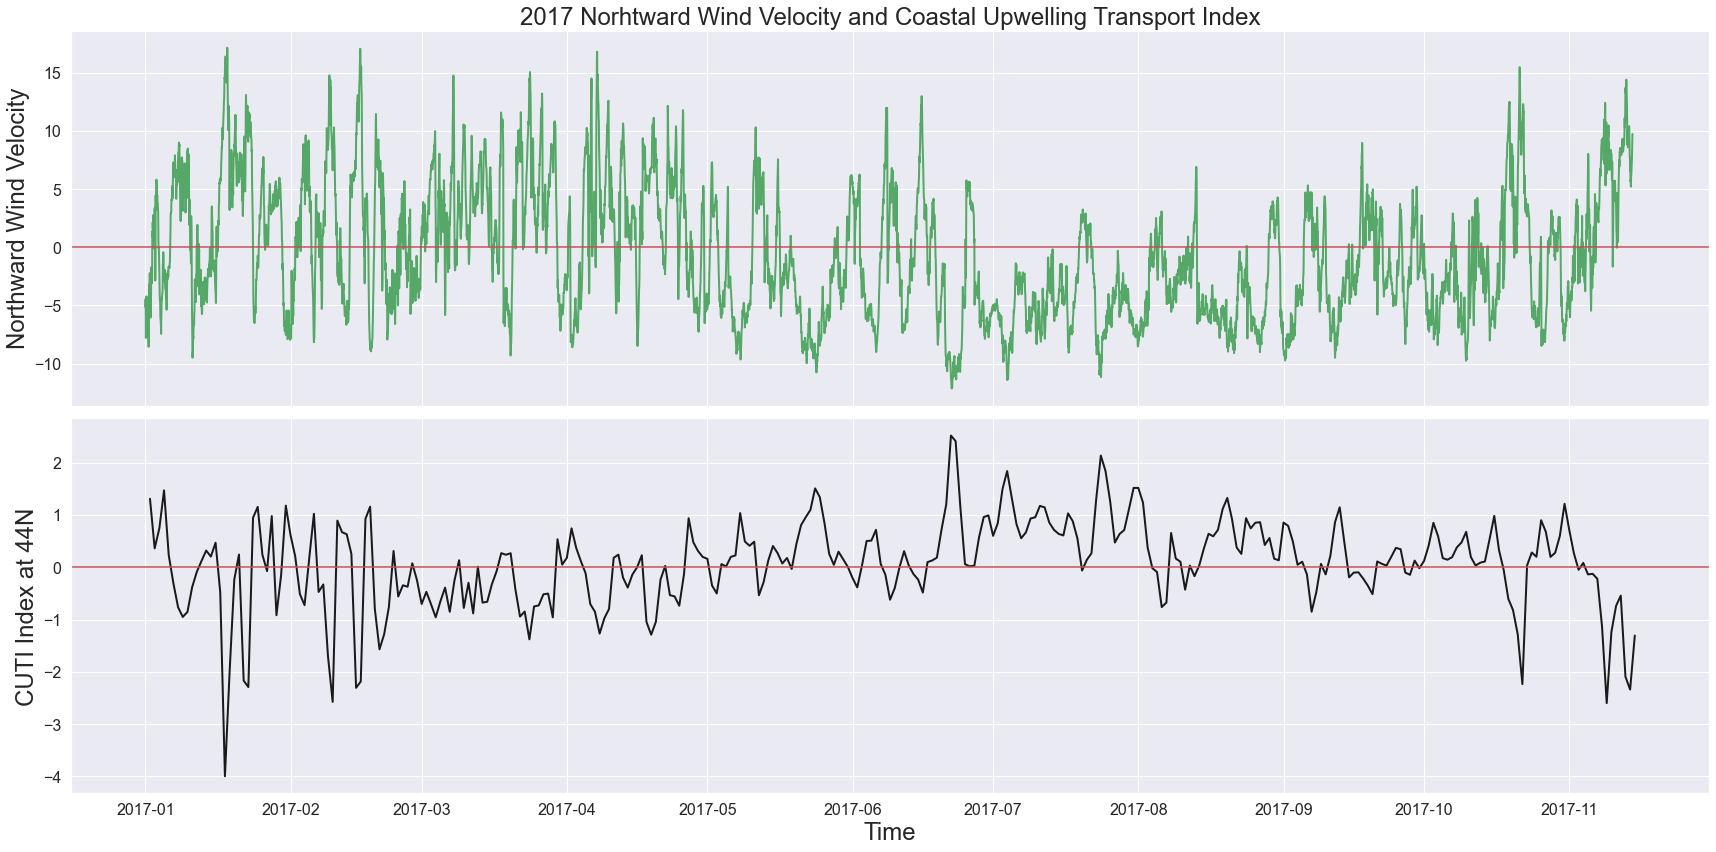

In [82]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(CUTI['time'], CUTI['44N'], 'k', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax2.set_title('2017 Norhtward Wind Velocity and Coastal Upwelling Transport Index', size=24)
ax1.axhline(y=0, ls='-', c='r') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['met_windavg_mag_corr_north'], 'g', linewidth=2)
ax2.set_ylabel('Northward Wind Velocity', size=24)
ax2.axhline(y=0, ls='-', c='r') # add horizontal line at 0
ax1.set_xlabel('Time', size=24)

ax2.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('../figures/CUTI_NWind.png')

Just as we'd expect, the positive northward velocities are associated with negative CUTI values, and the negative velocities are associated with positive CUTI values. 

Let's compare CUTI with SST next.

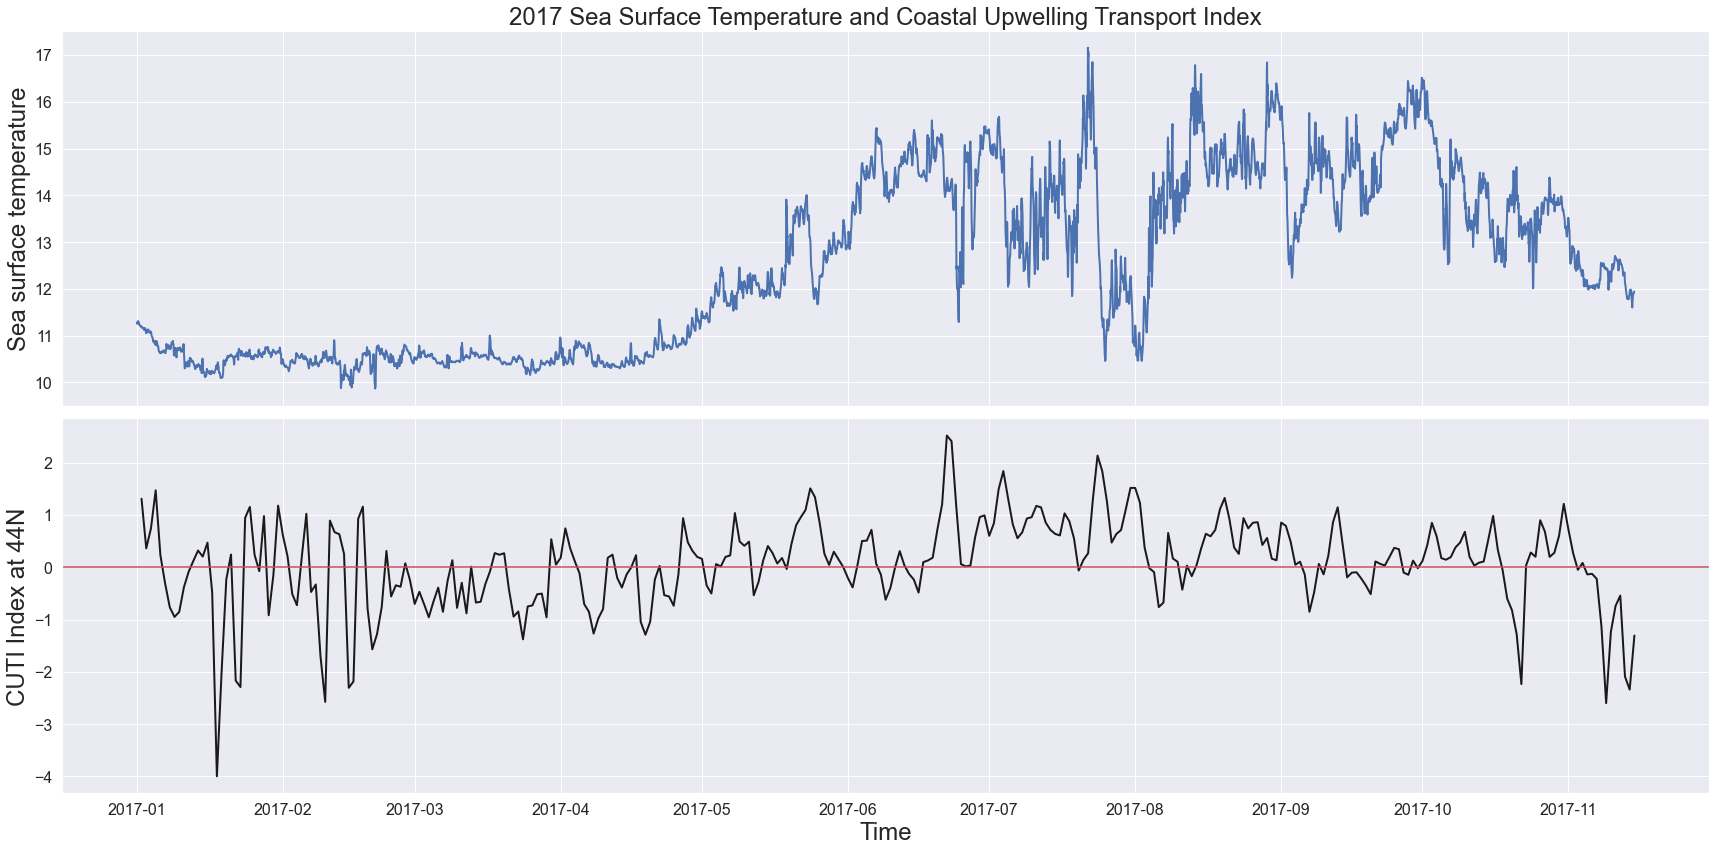

In [83]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(CUTI['time'], CUTI['44N'], 'k', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax2.set_title('2017 Sea Surface Temperature and Coastal Upwelling Transport Index', size=24)
ax1.axhline(y=0, ls='-', c='r') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['sea_surface_temperature'], 'b', label='SST', linewidth=2)
ax2.set_ylabel('Sea surface temperature', size=24)

ax1.set_xlabel('Time', size=24)

ax2.tick_params(labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('../figures/CUTI_SST.png')

By now you know what to look for when looking at these plots: downward spikes in SST aligned with positive CUTI values. From mid-May onward it's quite easy to spot several of these upwelling events based on the CUTI value and SST: around mid-May, towards the end of June, all throughout July and especially towards the start of August, and again at the start of Septemeber, maybe even the start of October.

We can quickly check correlations between the CUTI values and our variables to see which would be the best to include in a model if predicting the sign (positive or negative) of the CUTI values was our modeling goal. 

In [84]:
for var in profiler_var:
    n_obs = len(profiler_daily[var])
    correlation = CUTI['44N'][:n_obs].corr(profiler_daily[var])
    print(f'CUTI correlation with profiler {var} is', round(correlation, 4))

NameError: name 'profiler_daily' is not defined

In [ ]:
for var in platform_var:
    n_obs = len(platform_daily[var])
    correlation = CUTI['44N'][:n_obs].corr(platform_daily[var])
    print(f'CUTI correlation with platform {var} is', round(correlation, 4))

In [ ]:
for var in METBK_var:
    n_obs = len(METBK_daily[var])
    correlation = CUTI['44N'][:n_obs].corr(METBK_daily[var])
    print(f'CUTI correlation with surface mooring {var} is', round(correlation, 4))

The northward wind velocity had a correlation with sea_surface_temperature of -0.364434. The sign changed, but the correlation betweeh CUTI and SST is of similar magnitude. CUTI correlation with the 200 meter platform salinity, temperature, and density appear significant as well. Since density is calculated from temperature and salinity, I would opt to use only density or only salinity and temperature, but not all three. 

That concludes this simple look at 2017 data from the Oregon Offshore site. I did the same analysis with 2018 data from the same instrument packages, you can find it in the 03 notebook, or move on to the 04 preprocessing notebook to get straight to data processing and then modeling. 